### Word Embeddings Solution

###### Author: Alex Sherman | alsherman@deloitte.com


##### Agenda
- Vector Space Model
- PCA
- SVD
- Latent semantic indexing (LSI/LSA)
- Latent dirichlet allocation(LDA)
- Word2Vec
- Doc2Vec
- Category2Vec

In [70]:
from collections import defaultdict, Counter
from configparser import ConfigParser, ExtendedInterpolation
from IPython.core.display import display, HTML
from IPython.display import Image
from IPython.lib.display import YouTubeVideo
import pandas as pd
import numpy as np
import spacy
from spacy.matcher import Matcher, PhraseMatcher
from spacy.lang.en.stop_words import STOP_WORDS
import gensim
from gensim import corpora, models
from gensim.models.ldamodel import LdaModel
from gensim.models.callbacks import DiffMetric
from gensim.models import word2vec
from sklearn.feature_extraction.text import TfidfVectorizer
import pyLDAvis
import pyLDAvis.gensim
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### installation: 
# conda install pyldavis
# conda install visdom

config = ConfigParser(interpolation=ExtendedInterpolation())
config.read('../../config.ini')
GENSIM_DICTIONARY_PATH = config['NLP']['GENSIM_DICTIONARY_PATH']
GENSIM_CORPUS_PATH = config['NLP']['GENSIM_CORPUS_PATH']
AIRLINE_ACRONYMS_FILEPATH = config['NLP']['AIRLINE_ACRONYMS_FILEPATH']
AIRLINE_CLEANED_TEXT_PATH = config['NLP']['AIRLINE_CLEANED_TEXT_PATH']
AIRLINE_LSI_MODEL_PATH = config['NLP']['AIRLINE_LSI_MODEL_PATH']
AIRLINE_LDA_MODEL_PATH = config['NLP']['AIRLINE_LDA_MODEL_PATH']

### Word embedding
"Word embedding is the collective name for a set of language modeling and feature learning techniques in natural language processing (NLP) where words or phrases from the vocabulary are mapped to vectors of real numbers. Conceptually it involves a mathematical embedding from a space with one dimension per word to a continuous vector space with much higher dimension.

Methods to generate this mapping include neural networks, dimensionality reduction on the word co-occurrence matrix, probabilistic models, and explicit representation in terms of the context in which words appear.

Word and phrase embeddings, when used as the underlying input representation, have been shown to boost the performance in NLP tasks such as syntactic parsing and sentiment analysis."

##### There are many techniques to create Word Embeddings. Some of the popular ones are:

- Binary Encoding
- TF Encoding
- TF-IDF Encoding
- Latent Semantic Analysis Encoding
- Topic Modeling
- Word2Vec Encoding

SOURCE: https://en.wikipedia.org/wiki/Word_embedding

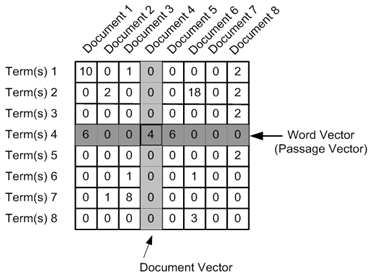

In [2]:
# Document and Word Vectors
Image("../../raw_data/images/word_vector.png", width=400, height=400)

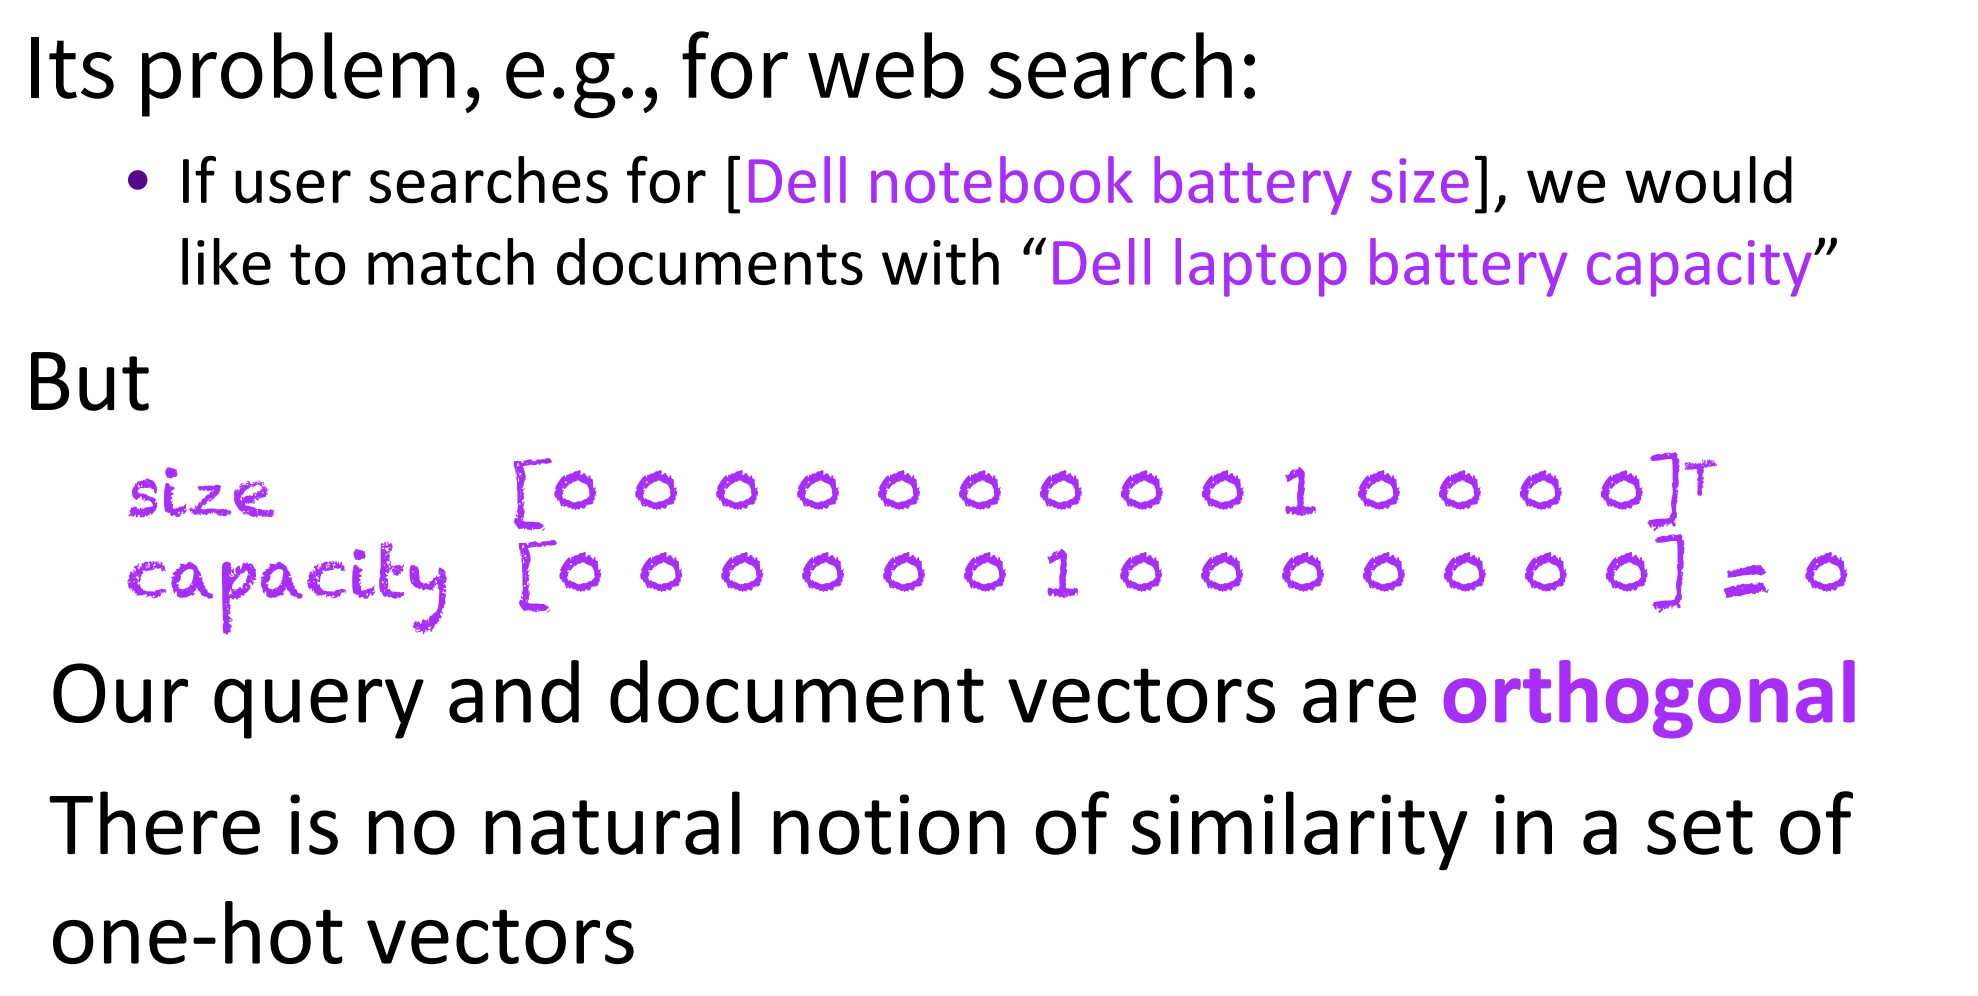

In [3]:
# problems with symbolic word representations
Image("../../raw_data/images/symbolic_word_representations.png", width=400)

In [4]:
with open(AIRLINE_CLEANED_TEXT_PATH, 'r') as f:
    texts = list(set([row.strip() for row in f]))

# convert each line of text into a list of tokens for gensim
texts = [text.split() for text in texts]

print(texts[0])

['unlike', 'many', 'of', 'our', 'competitor', 'we', 'do', 'not', 'charge', 'a', 'rebook', 'or', 'exchange', 'fee', 'for', 'customers', 'who', 'change', 'their', 'itinerary', 'nor', 'have', 'we', 'ever', 'require', 'a', 'saturday', 'night', 'stay']


# Text Vectorization (gensim)

In [5]:
gensim_url = r'https://radimrehurek.com/gensim/index.html'
iframe = '<iframe src={} width=950 height=300></iframe>'.format(gensim_url)
HTML(iframe)

In [6]:
from gensim import corpora

example_text = [['computer','human', 'interface']]

# fit dictionary
# documents: Documents that used for initialization
# prune_at:  Dictionary will keep not more than prune_at words
dct = corpora.Dictionary(example_text, prune_at=2000000)  

# update dictionary with new documents - useful if text corpora doesn't fit in memory
dct.add_documents([['data','science'], ['user','interface']])

dct.doc2bow(["interface", "computer", "non_existent_word"], return_missing=True)

([(0, 1), (2, 1)], {'non_existent_word': 1})

Here we assigned a unique integer ID to all words appearing in the processed corpus with the gensim.corpora.dictionary.Dictionary class. 

This sweeps across the texts, collecting word counts and relevant statistics. In the end, we see distinct words in the processed corpus, which means each document will be represented by n numbers (ie., by a n-D vector).

In [7]:
# turn our tokenized documents into a id <-> term dictionary

dictionary = corpora.Dictionary(texts)
print(dictionary)

Dictionary(1078 unique tokens: ['company_ability', 'bump', 'impose_noise', 'therefore', 'southwest_doe']...)


In [8]:
# num_docs – number of documents processe
print('num docs: {}'.format(dictionary.num_docs))

# num_pos – total number of  processed words
print('num pos: {}'.format(dictionary.num_pos))

num docs: 218
num pos: 5592


##### filter_extremes

- **no_below (int, optional)** – Keep tokens which are contained in at least no_below documents.
- **no_above (float, optional)** – Keep tokens which are contained in no more than no_above documents (fraction of total corpus size, not an absolute number).
- **keep_n (int, optional)** – Keep only the first keep_n most frequent tokens.
- **keep_tokens (iterable of str)** – Iterable of tokens that must stay in dictionary after filtering.

In [9]:
# filter the dictionary to remove infrequent (no_below) and too frequent (no_above) terminology
dictionary.filter_extremes(no_below=.01, no_above=0.05)

In [10]:
print(dictionary.token2id)

{'company_ability': 780, 'aircraft_operate': 92, 'impose_noise': 794, 'therefore': 638, 'southwest_doe': 339, 'also': 337, 'confirmation_and_viii': 433, 'inflation': 209, 'generate_much_net': 480, 'authority_action': 774, 'cancel_or_oversell': 157, 'quickly': 554, 'fee_must_be_disclose': 439, 'increase_land': 503, 'miles_rewards': 314, 'unfunded': 749, 'spend': 897, 'percent_compare': 858, 'equitable': 586, 'counter': 662, 'bump': 995, 'card_process': 134, 'domestic_and_foreign': 788, 'card': 984, 'united_states': 942, 'allow_to_cancel': 959, 'fleet': 606, 'power': 745, 'relocation': 760, 'increase_after_purchase': 966, 'initiative_a_previously': 600, 'advance_seat': 146, 'istration': 921, 'same': 266, 'service': 281, 'major_competitor': 59, 'rule': 228, 'ancillary_service': 148, 'remand': 919, 'many': 5, 'direct': 541, 'impose_bag': 655, 'reverse': 674, 'time': 244, 'business_through_the_imposition': 389, 'reduction': 736, 'curb_side_checkin': 332, 'december': 205, 'disclose_all_poten

##### doc2bow()
The function doc2bow() counts the number of occurrences of each distinct word, converts the word to its integer word id and returns the result as a bag-of-words--a sparse vector, in the form of [(word_id, word_count), ...].

For people familiar with scikit learn, doc2bow() has similar behaviors as calling transform() on CountVectorizer. doc2bow() can behave like fit_transform() as well. For more details, please look at gensim API Doc.

In [11]:
# map two documetns using doc to bag of words

print('Document 0: {}'.format(texts[0]))
print(dictionary.doc2bow(texts[0]))

print('\nDocument 1: {}'.format(texts[1]))
print(dictionary.doc2bow(texts[1]))

Document 0: ['unlike', 'many', 'of', 'our', 'competitor', 'we', 'do', 'not', 'charge', 'a', 'rebook', 'or', 'exchange', 'fee', 'for', 'customers', 'who', 'change', 'their', 'itinerary', 'nor', 'have', 'we', 'ever', 'require', 'a', 'saturday', 'night', 'stay']
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1)]

Document 1: ['the', 'government', 'conjurer', 'waive', 'the', 'requirement', 'that', 'security', 'fee', 'be', 'collect', 'on', 'airline', 'ticket', 'issue', 'from', 'june', 'to', 'september']
[(16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1)]


In [12]:
# notice that 'be' appears in both documents and is mapped to the same id
print(dictionary[2])

# the second number in each tuple is the count
print(dictionary.doc2bow(['by','by','by']))

ever
[]


In [13]:
# convert tokenized documents into a document-term matrix in a sparse representation
corpus = [dictionary.doc2bow(sent) for sent in texts]
print('Sentence 1 BOW:\n {}\n'.format(corpus[0]))
print('Sentence 2 BOW:\n {}'.format(corpus[1]))

Sentence 1 BOW:
 [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1)]

Sentence 2 BOW:
 [(16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1)]


In [14]:
# initialize a tfidf model (similary to TfidfTransformer from sklearn)
tfidf = models.TfidfModel(corpus)
print('TFIDF for sentent 0:\n {}\n'.format(tfidf[corpus[0]]))
print('TFIDF for sentent 1:\n {}'.format(tfidf[corpus[1]]))

TFIDF for sentent 0:
 [(0, 0.26915033246602915), (1, 0.21423490227281755), (2, 0.23450255362695555), (3, 0.26915033246602915), (4, 0.26915033246602915), (5, 0.199854774787882), (6, 0.26915033246602915), (7, 0.26915033246602915), (8, 0.18870068135414036), (9, 0.23450255362695555), (10, 0.21423490227281755), (11, 0.26915033246602915), (12, 0.23450255362695555), (13, 0.23450255362695555), (14, 0.37740136270828073), (15, 0.18870068135414036)]

TFIDF for sentent 1:
 [(16, 0.24324178053962764), (17, 0.2522305863034254), (18, 0.23520101978707994), (19, 0.35802791674334095), (20, 0.4109265819632988), (21, 0.28809968500703775), (22, 0.3270841812514632), (23, 0.28809968500703775), (24, 0.28809968500703775), (25, 0.4109265819632988)]


In [15]:
# convert the entire corpus to tfidf
tfidf_vect = [tfidf[corpus[i]] for i in range(0, len(corpus))]

In [16]:
# save the dictionary - we will use it again in different lessons
print('GENSIM_DICTIONARY_PATH: {}'.format(GENSIM_DICTIONARY_PATH))
dictionary.save(GENSIM_DICTIONARY_PATH)  

GENSIM_DICTIONARY_PATH: C:\Users\alsherman\Desktop\PycharmProjects\firm_initiatives\ml_guild\raw_data/gensim/airline_dict.dict


In [17]:
# store to disk - we will use it again in different notebooks
print('GENSIM_CORPUS_PATH: {}'.format(GENSIM_CORPUS_PATH))
corpora.MmCorpus.serialize(GENSIM_CORPUS_PATH, corpus)

GENSIM_CORPUS_PATH: C:\Users\alsherman\Desktop\PycharmProjects\firm_initiatives\ml_guild\raw_data/gensim/airline.mm


##### Limitations of the vector space model:

We generally do not want to feed a large number of features directly into a machine learning algorithm because:
- They are expensive to store.
- They slow down computations (e.g. in algorithms like k nearest neighbors)
- Large samples are required to avoid overfitting.


**Synonymy:** the characteristic of language to have several terms that mean essentially the same thing
-  In the SAS technical support data set the terms “frozen” and “hangs” often refer to the same situation where the program has reached a point where nothing is happening and yet the user cannot continue working

**Polysemy:** is the tendency for the same term to mean different things in different contexts.
- The term “monitor” in technical support data is a good example of this. At times it refers to the computer screen, sometimes it refers to a piece of software that displays a graphical result and still other times it refers to the user “watching” or “observing” an event

**Term dependence:** refers to the tendency for certain terms to be highly correlated with one another. This problem is not unique to text but also occurs with most other sets of data as well. 
- The terms “error” and “message” are strongly correlated in the technical support collection. When one occurs, the other also tends to occur. A pair of documents, each containing these two terms, may have their similarity overrated in this case

SOURCE: 
- https://davidrosenberg.github.io/ml2015/docs/13.Lab.PCA-SVD-LDA.pdf
- ftp://ftp.sas.com/techsup/download/EMiner/TamingTextwiththeSVD.pdf

## Dimensionality Reduction and Semantic Transformations

### Principal Component Analysis (PCA)

The sheer size of data in the modern age is not only a challenge for computer hardware but also a main bottleneck for the performance of many machine learning algorithms. The main goal of a PCA analysis is to identify patterns in data; PCA aims to detect the correlation between variables. If a strong correlation between variables exists, the attempt to reduce the dimensionality only makes sense. In a nutshell, this is what PCA is all about: Finding the directions of maximum variance in high-dimensional data and project it onto a smaller dimensional subspace while retaining most of the information.

- Principal Component Analysis (PCA) is a dimension-reduction tool that can be used to reduce a large set of variables to a small set that still contains most of the information in the large set.
- Principal component analysis (PCA) is a mathematical procedure that transforms a number of (possibly) correlated variables into a (smaller) number of uncorrelated variables called principal components. 
- PCA is used to decompose a multivariate dataset in a set of successive orthogonal components that explain a maximum amount of the variance
- The first principal component accounts for as much of the variability in the data as possible, and each succeeding component accounts for as much of the remaining variability as possible.

SOURCE: 
- [Principal Component Analysis
in 3 Simple Steps](http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html)
- [Introduction to Principal
Components and FactorAnalysis](ftp://statgen.ncsu.edu/pub/thorne/molevoclass/AtchleyOct19.pdf)

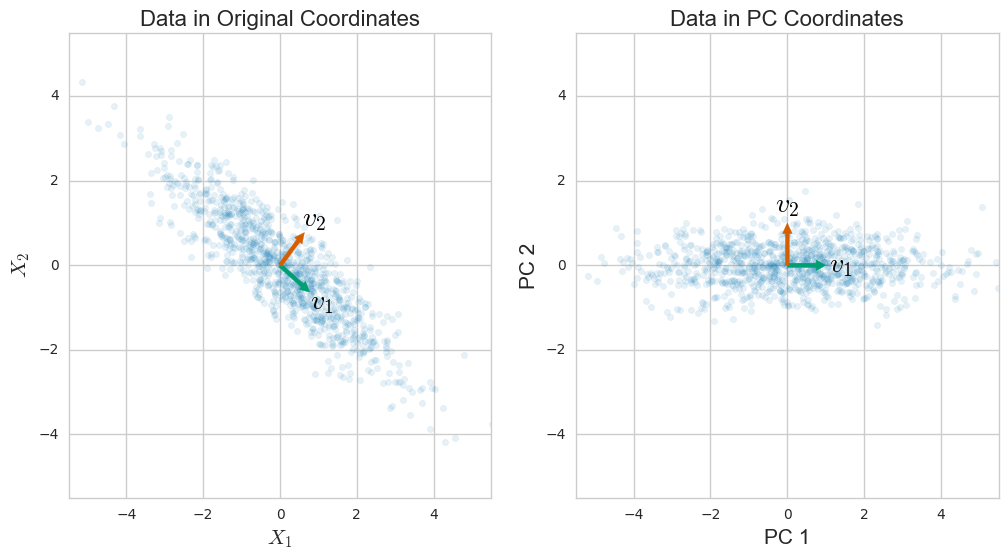

In [18]:
# PCA
# SOURCE: https://intoli.com/blog/pca-and-svd/
Image("../../raw_data/images/pca.png", width=700, height=700)

In [19]:
import numpy as np
from sklearn.decomposition import PCA

X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
X_df = pd.DataFrame(X)
X_df

,0,1
0,-1,-1
1,-2,-1
2,-3,-2
3,1,1
4,2,1
5,3,2


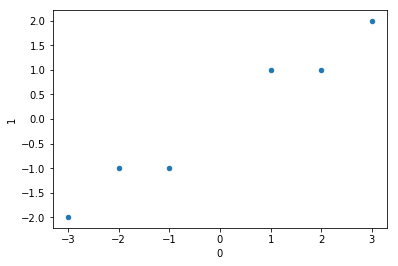

In [20]:
X_df.plot.scatter(x=0, y=1)

In [21]:
pca = PCA(n_components=2)
fit_pca = pca.fit_transform(X_df)

# print out the transformed matrix
pca_df = pd.DataFrame(fit_pca, columns=['component 1','component 2'])
pca_df

,component 1,component 2
0,1.383406,0.293579
1,2.221898,-0.251335
2,3.605304,0.042244
3,-1.383406,-0.293579
4,-2.221898,0.251335
5,-3.605304,-0.042244


(-2, 2)

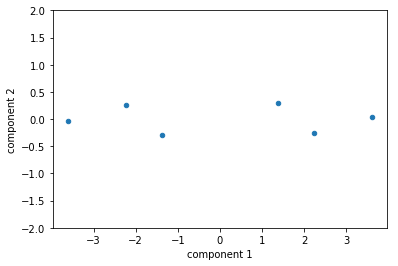

In [22]:
# plot the prinipal components
pca_df.plot.scatter(x='component 1', y='component 2')

# increase range of y-axis
plt.ylim(-2,2)

The eigenvectors and eigenvalues of a covariance (or correlation) matrix represent the “core” of a PCA: The eigenvectors (principal components) determine the directions of the new feature space, and the eigenvalues determine their magnitude. In other words, the eigenvalues explain the variance of the data along the new feature axes.

In [23]:
print('Singular values: {}'.format(pca.singular_values_.round(2)))

# Singular Values are the l2 norm of each component
# e.g. np.sqrt(sum([i**2 for i in pca_df['component 1']]))
print('Singluar Value 1: {}'.format(np.linalg.norm(pca_df['component 1'], ord=2).round(2)))
print('Singluar Value 2: {}'.format(np.linalg.norm(pca_df['component 2'], ord=2).round(2)))

print('\nExplained variance ratio: {}'.format(pca.explained_variance_ratio_))

Singular values: [6.3  0.55]
Singluar Value 1: 6.3
Singluar Value 2: 0.55

Explained variance ratio: [0.99244289 0.00755711]


In [24]:
print('Components:\n {}'.format(pca.components_.round(2)))

Components:
 [[-0.84 -0.54]
 [ 0.54 -0.84]]


##### Recreate PCA through SVD

In [25]:
# transpose X_df by using .T
X_df.T

,0,1,2,3,4,5
0,-1,-2,-3,1,2,3
1,-1,-1,-2,1,1,2


In [26]:
# recreate PCA using SVD (we will explain this calculation in the next section)
u,s,vt = np.linalg.svd(X_df)
print("singular values =\n", np.round(s, decimals=2), "\n")
print("components =\n", np.round(vt, decimals=2), "\n")

u,s,vt = np.linalg.svd(X_df.T)
pd.DataFrame(X_df.dot(u))

singular values =
 [6.3  0.55] 

components =
 [[ 0.84  0.54]
 [ 0.54 -0.84]] 



,0,1
0,1.383406,-0.293579
1,2.221898,0.251335
2,3.605304,-0.042244
3,-1.383406,0.293579
4,-2.221898,-0.251335
5,-3.605304,0.042244


### Singular Value Decomposition

In linear algebra, the singular-value decomposition (SVD) is a factorization of a real or complex matrix.

Let A be an m × n term-document frequency matrix with rank r, r ≤ n. Without loss of generality let m ≥ n hold so that there are more terms than documents. The singular value decomposition of A can be stated succinctly as A = U*Σ*VT,

- U is an m × r orthogonal matrix whose columns make up the left singular vectors
- Σ is an r × r dimensional diagonal matrix whose diagonal elements are termed singular values
- V is an r × northogonal matrix whose columns form the right singular vectors of A.

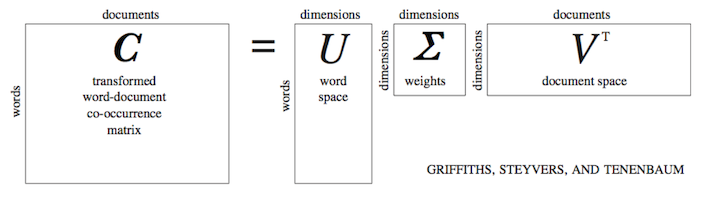

In [27]:
# SVD
Image("../../raw_data/images/svd_graph.png", width=700, height=700)

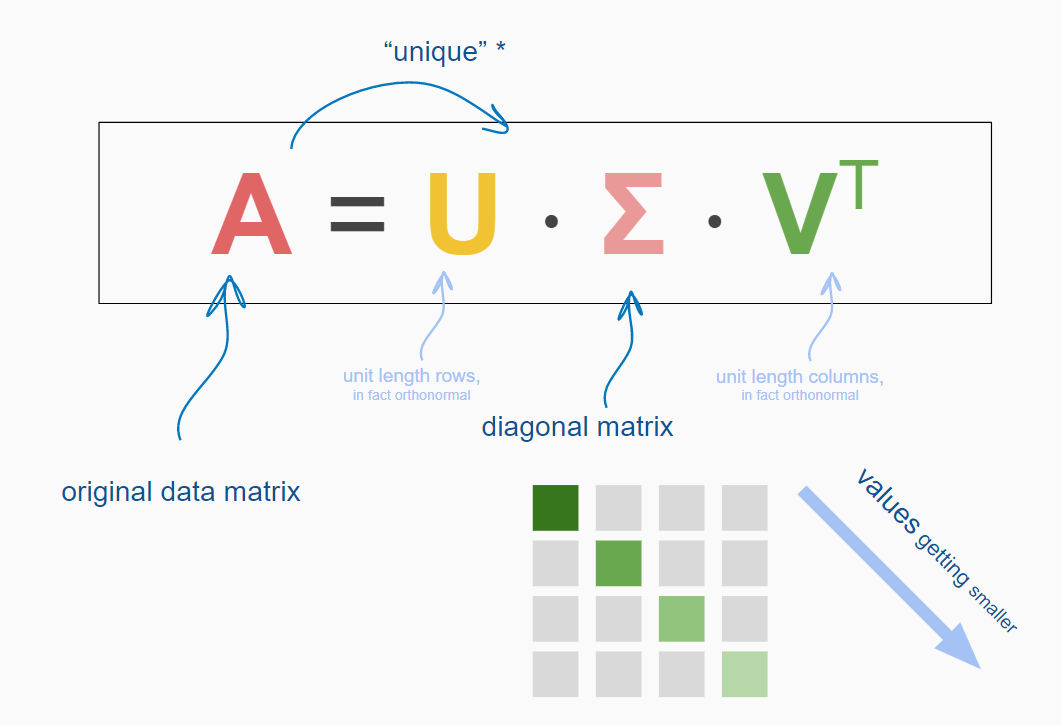

In [28]:
# SVD
Image("../../raw_data/images/svd3.png", width=400)

##### Reduced SVD

The SVD comes in two forms, a full SVD, and a reduced SVD. In NLP, we tend to focus on the reduced SVD, using SVD for dimensionality reduction.

SVD can be viewed as a sum of rank one matrices.The matrix A can then be approximated by choosing any k ≤ r. This generates a rank k matrix, Ak, that is the best rank-k approximation to A in terms of least-squares best fit

SOURCE: ftp://ftp.sas.com/techsup/download/EMiner/TamingTextwiththeSVD.pdf

"Singlular Value Decomposition (SVD) allows us to reduce the dimensionality of a matrix. Instead of analyzing a full document-term matrix with all documents and all terms, we can reduce the matrix into a lower rank representation. In this, we combine the meaning of terms by compressing the number of columns.

To reduce the size of our matrix without losing much quality, we can perform a low-rank approximation on matrix C. This is done by keeping the top k values of Σ and setting the rest to zero, where k is the new rank. Since Σ contains eigenvalues in descending order, and the effect of small eigenvalues on matrix products is small, the zeroing of the lowest values will leave the reduced matrix C' approximate to C. How to retrieve the most optimal k is not an easy task, since we want k top large enough to include as much variety as possible from our original matrix C, but small enough to exclude sampling errors and redundancy. To do this in a formal way, the Frobenius norm can be applied to measure the discrepancy between C and C_k. A less extensive way is just to try out a couple of different k-values and see what generates the best results."

SOURCE: https://simonpaarlberg.com/post/latent-semantic-analyses/

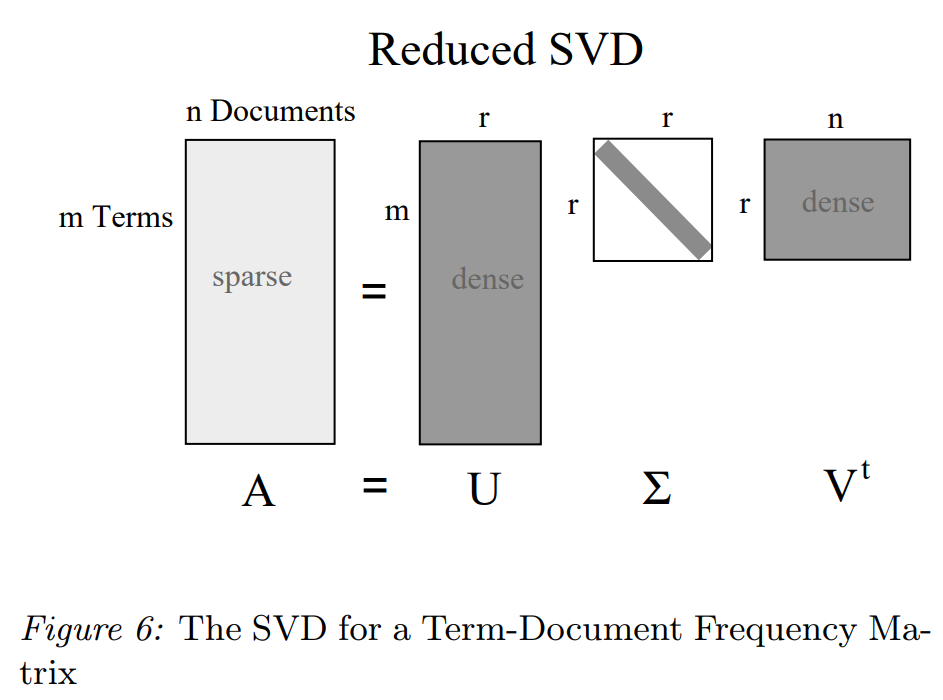

In [29]:
# reduced SVD
Image("../../raw_data/images/reduced_svd.png", width=500, height=700)

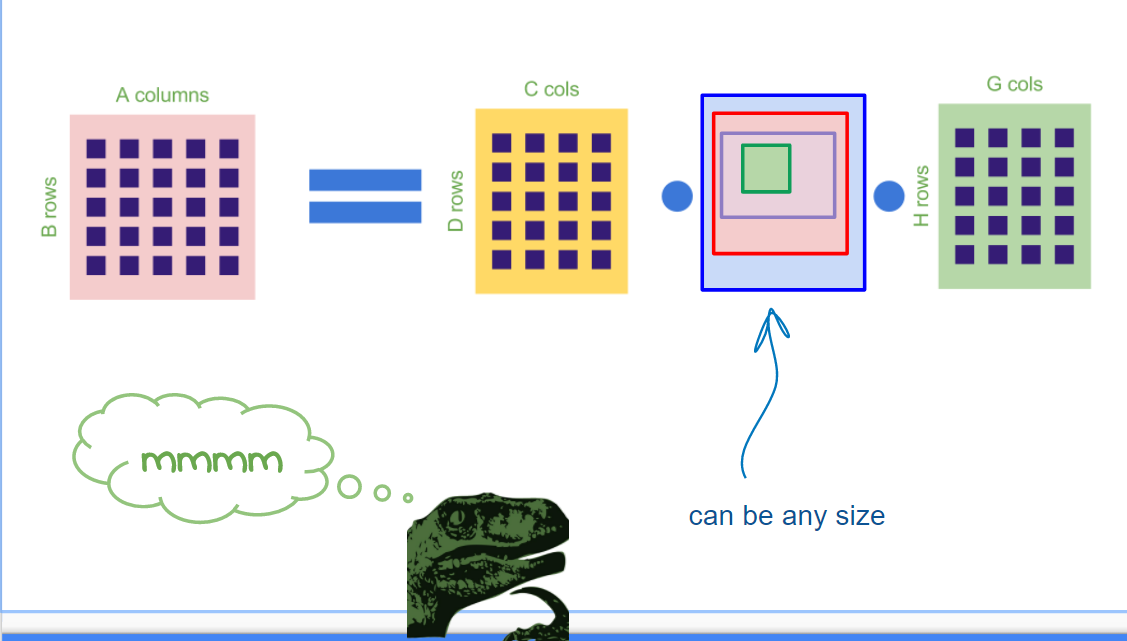

In [30]:
# SVD
Image("../../raw_data/images/svd2.png", width=700)

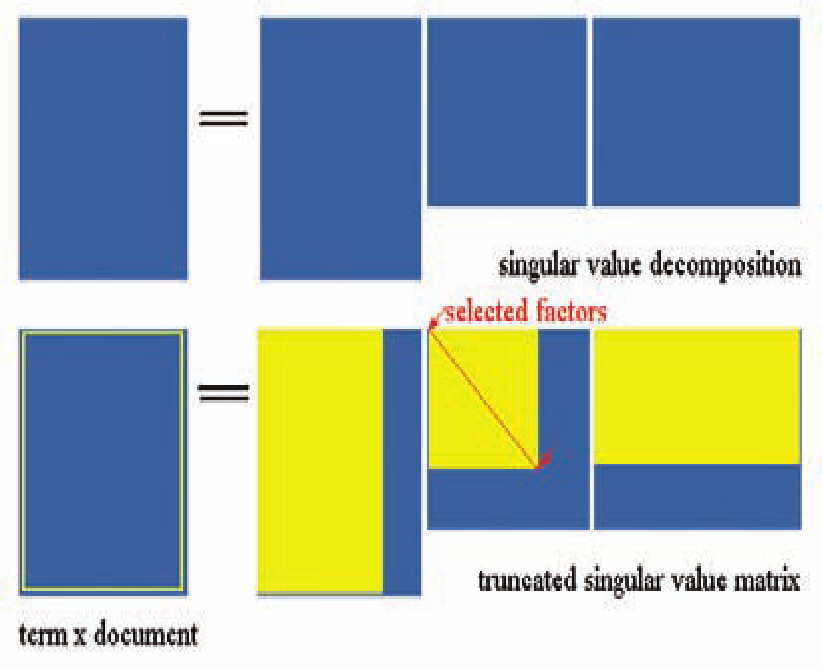

In [31]:
# Truncated SVD
# SOURCE: https://www.researchgate.net/figure/Singular-value-decomposition-SVD-and-a-truncated-SVD-matrix_fig1_227060873
Image("../../raw_data/images/truncated_svd.png", width=500)

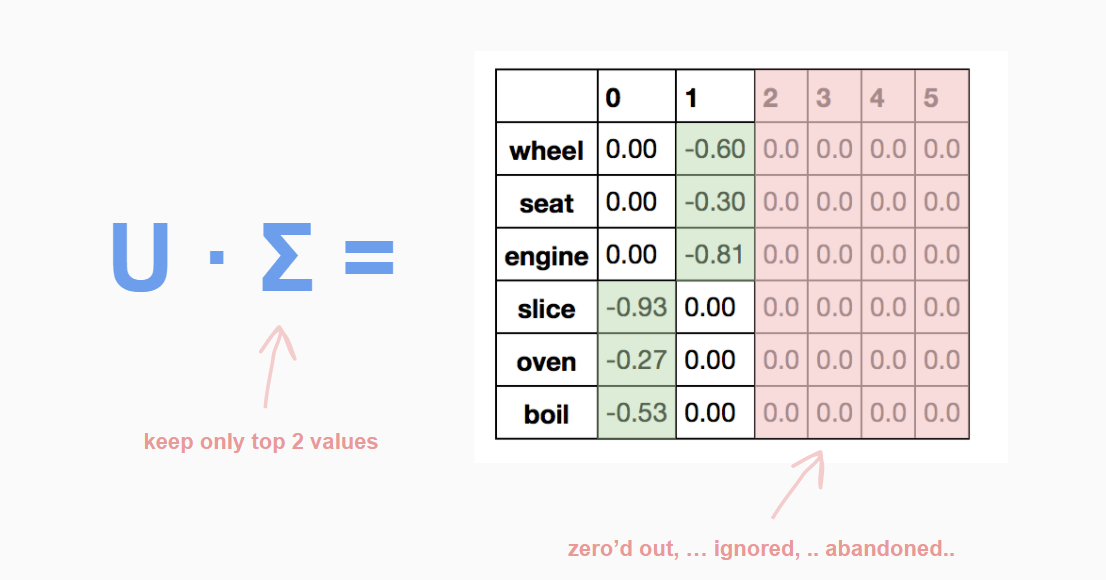

In [32]:
# SVD
Image("../../raw_data/images/svd4.png", width=700, height=700)

##### SVD approximation equation
Equation 1 implies that one can get a rough approximation to A by taking the product of the first singular value with the matrix formed from the outer product of the first column of U with the first column of V . The matrix formed, A1, will be m × n but will be of only rank one. Of all possible matrices, B, of rank one, ||A − B||2 will be smallest when B = A1 holds. One can improve the approximation by forming the product of the second singular value with the outer product of the second columns of U and V , and then adding this result to A1. The resultant matrix, A2, will be the the best rank-two approximation to A. The approximations can be successively improved by repeating the process until k = r holds and the original matrix is produced.

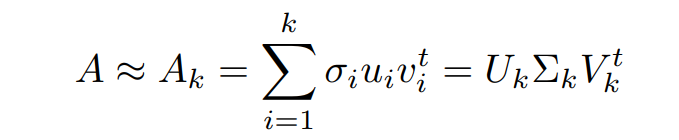

In [33]:
# reduced SVD equation
Image("../../raw_data/images/svd_truncated_equation.png", width=500, height=700)

##### Coursera Course on SVD

SOURCE: https://www.coursera.org/learn/matrix-factorization/lecture/K5NBy/singular-value-decomposition

### SVD Example

In [34]:
import numpy
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

In [35]:
print(texts[0])

['unlike', 'many', 'of', 'our', 'competitor', 'we', 'do', 'not', 'charge', 'a', 'rebook', 'or', 'exchange', 'fee', 'for', 'customers', 'who', 'change', 'their', 'itinerary', 'nor', 'have', 'we', 'ever', 'require', 'a', 'saturday', 'night', 'stay']


In [36]:
# combine tokens into sentences
svd_data = [' '.join(text) for text in texts[0:8]]

# create a document term matrix of the token counts
vect = CountVectorizer(max_features=10, stop_words='english')
dtm = vect.fit_transform(svd_data)
vocab = vect.get_feature_names()
df = pd.DataFrame(dtm.toarray(), columns=vocab)
df

,1_quarter,bag,change,charge,collect,company,customers,fee,major_competitor,september
0,0,0,1,1,0,0,1,1,0,0
1,0,0,0,0,1,0,0,1,0,1
2,2,0,0,0,0,0,0,0,0,0
3,0,1,1,0,0,1,0,3,0,0
4,0,0,0,0,0,0,0,1,0,0
5,0,0,0,0,1,0,1,1,0,0
6,0,1,0,1,0,1,0,1,1,0
7,0,0,0,0,0,0,0,2,0,1


In [37]:
# decompose the matrix using SVD
U, s, VT = numpy.linalg.svd(df, full_matrices=False)
S = numpy.diag(s)

In [38]:
# what are U, S and V
print("U =\n", numpy.round(U, decimals=2), "\n")
print("S =\n", numpy.round(S, decimals=2), "\n")
print("V^T =\n", numpy.round(VT, decimals=2), "\n")

U =
 [[-0.28 -0.1  -0.    0.78  0.25 -0.46 -0.17 -0.08]
 [-0.24  0.51 -0.   -0.06 -0.48 -0.05 -0.61 -0.27]
 [ 0.   -0.   -1.   -0.   -0.    0.   -0.    0.  ]
 [-0.71 -0.21  0.   -0.26  0.43  0.36 -0.27  0.07]
 [-0.19  0.09 -0.   -0.09  0.11 -0.01  0.45 -0.86]
 [-0.23  0.35 -0.    0.48 -0.22  0.6   0.38  0.2 ]
 [-0.32 -0.64  0.   -0.   -0.68 -0.09  0.14 -0.01]
 [-0.41  0.39  0.   -0.29 -0.02 -0.54  0.4   0.38]] 

S =
 [[4.71 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   2.05 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   2.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.72 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.42 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.06 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.65 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.22]] 

V^T =
 [[ 0.   -0.22 -0.21 -0.13 -0.1  -0.22 -0.11 -0.89 -0.07 -0.14]
 [-0.   -0.41 -0.15 -0.36  0.42 -0.41  0.13  0.18 -0.31  0.44]
 [-1.    0.   -0.   -0.   -0.    0.   -0.    0.    0.    0.  ]
 [-0.   -0.15  0.3   0.45  0.24 -0.1

In [39]:
# U and V are othonormal
# These vectors are orthogonal to one another; form a basis for the reduced space

# each vector is normalized (unit vector)
# multiply by itself returns 1
col1 = np.array([i[0] for i in U])
print(col1.dot(col1))

col2 = np.array([i[1] for i in U])
print(col2.dot(col2))

# and each vector is orthogonal to the other vectors
# multiply different vectors returns 0
col1.dot(col2)

1.0000000000000004
1.0000000000000007


-1.1102230246251565e-16

In [40]:
# rebuild A2 from U.S.V
A2 = numpy.dot(U, numpy.dot(S, VT))
print("A2 =\n", numpy.round(A2, decimals=2))

A2 =
 [[ 0. -0.  1.  1.  0. -0.  1.  1. -0.  0.]
 [-0.  0. -0.  0.  1.  0. -0.  1.  0.  1.]
 [ 2. -0. -0.  0.  0. -0.  0.  0.  0. -0.]
 [-0.  1.  1. -0. -0.  1. -0.  3. -0. -0.]
 [ 0. -0.  0. -0.  0. -0. -0.  1. -0. -0.]
 [ 0.  0. -0.  0.  1.  0.  1.  1.  0. -0.]
 [-0.  1. -0.  1.  0.  1.  0.  1.  1.  0.]
 [-0.  0. -0.  0. -0. -0.  0.  2.  0.  1.]]


In [41]:
# S_reduced is the same as S but with only the top n elements kept
S_reduced = numpy.zeros_like(S)

# only keep top two eigenvalues
eigen_num = 3
S_reduced[:eigen_num, :eigen_num] = S[:eigen_num,:eigen_num]

# show S_rediced which has less info than original S
print("S_reduced =\n", numpy.round(S_reduced, decimals=2))

S_reduced =
 [[4.71 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   2.05 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   2.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]]


In [42]:
# what is the document matrix now?
S_reduced_VT = numpy.dot(S_reduced, VT)
print("S_reduced_VT = \n", numpy.round(S_reduced_VT, decimals=2))

S_reduced_VT = 
 [[ 0.   -1.03 -0.99 -0.61 -0.47 -1.03 -0.52 -4.21 -0.32 -0.65]
 [-0.   -0.84 -0.3  -0.73  0.86 -0.84  0.26  0.37 -0.64  0.9 ]
 [-2.    0.   -0.   -0.   -0.    0.   -0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]]


In [43]:
# each Singular Value vector is a linear combination of original words
U_S_reduced = numpy.dot(U, S_reduced)
df = pd.DataFrame(numpy.round(U_S_reduced, decimals=2), index=vocab[0:8])

# show colour coded so it is easier to see significant word contributions to a topic
df.style.background_gradient(cmap=plt.get_cmap('Blues'))

,0,1,2,3,4,5,6,7
1_quarter,-1.34,-0.2,-0,0,0,0,0,0
bag,-1.13,1.04,-0,0,0,0,0,0
change,0,-0,-2,0,0,0,0,0
charge,-3.33,-0.42,0,0,0,0,0,0
collect,-0.89,0.18,-0,0,0,0,0,0
company,-1.1,0.73,-0,0,0,0,0,0
customers,-1.53,-1.31,0,0,0,0,0,0
fee,-1.92,0.8,0,0,0,0,0,0


##### When is the SVD Technique Appropriate?
For most Text Mining problems, the SVD will be entirely appropriate to use. Without a data reduction technique, there will be more variables (terms) available than one can use in a data mining model. Some method must be applied to select an appropriate set from which a text mining solution can be built. Unlike term elimination, the SVD technique allows one to derive significantly fewer variables from the original variables. There are some drawbacks to using the SVD, however. Computationally, the SVD is fairly resource intensive and requires a large amount of RAM. The user must have access to these resources in order for the decomposition to be obtained.

##### How Many Dimensions Should be Used?
The choice for the number of dimensions k to use can be a crucial aspect of many text mining solutions. With too few dimensions, the model will fail to explain prominent relationships in the text. On the other hand, using too many dimensions will add unnecessary noise to the model and make training an effective model nearly impossible. In practice, there is an upper bound of at most a few hundred dimensions from which to build a model. So the user should not need to consider more than this

### SVD in comparision to PCA
Using the below image displaying several documents that contain only two terms (A&B)

**SVD:** draw a line through the points in such a way that the sum of the distances from each point to the line is minimized. The documents can then be perpendicularly projected onto this new line. The circles indicate the locations of the projected documents. This line and the new locations for the documents, can be obtained by using the SVD

**PCA:** Spread the points out as much as possible on this new line to maximize the variance of the points that are projected onto the line. This line is formed by performing Principal Component Analysis

Although based on equivalent procedures, since PCA and TM’s SVD approach operate on different data, they do not produce the same results. Depending on whether the raw data is used or the covariance matrix is used, different vectors will be found as basis vectors for the reduced space

While the PCA component maximizes the variance, the SVD finds the best fitting line in the least-squares sense. The SVD line is affected by the dispersement of Word_B when Word_A occurs between 0 and 10 times while the PCA line is not influenced by this secondary variation. Depending on the nature of the data, these two lines may or may not be fairly close to one another. 

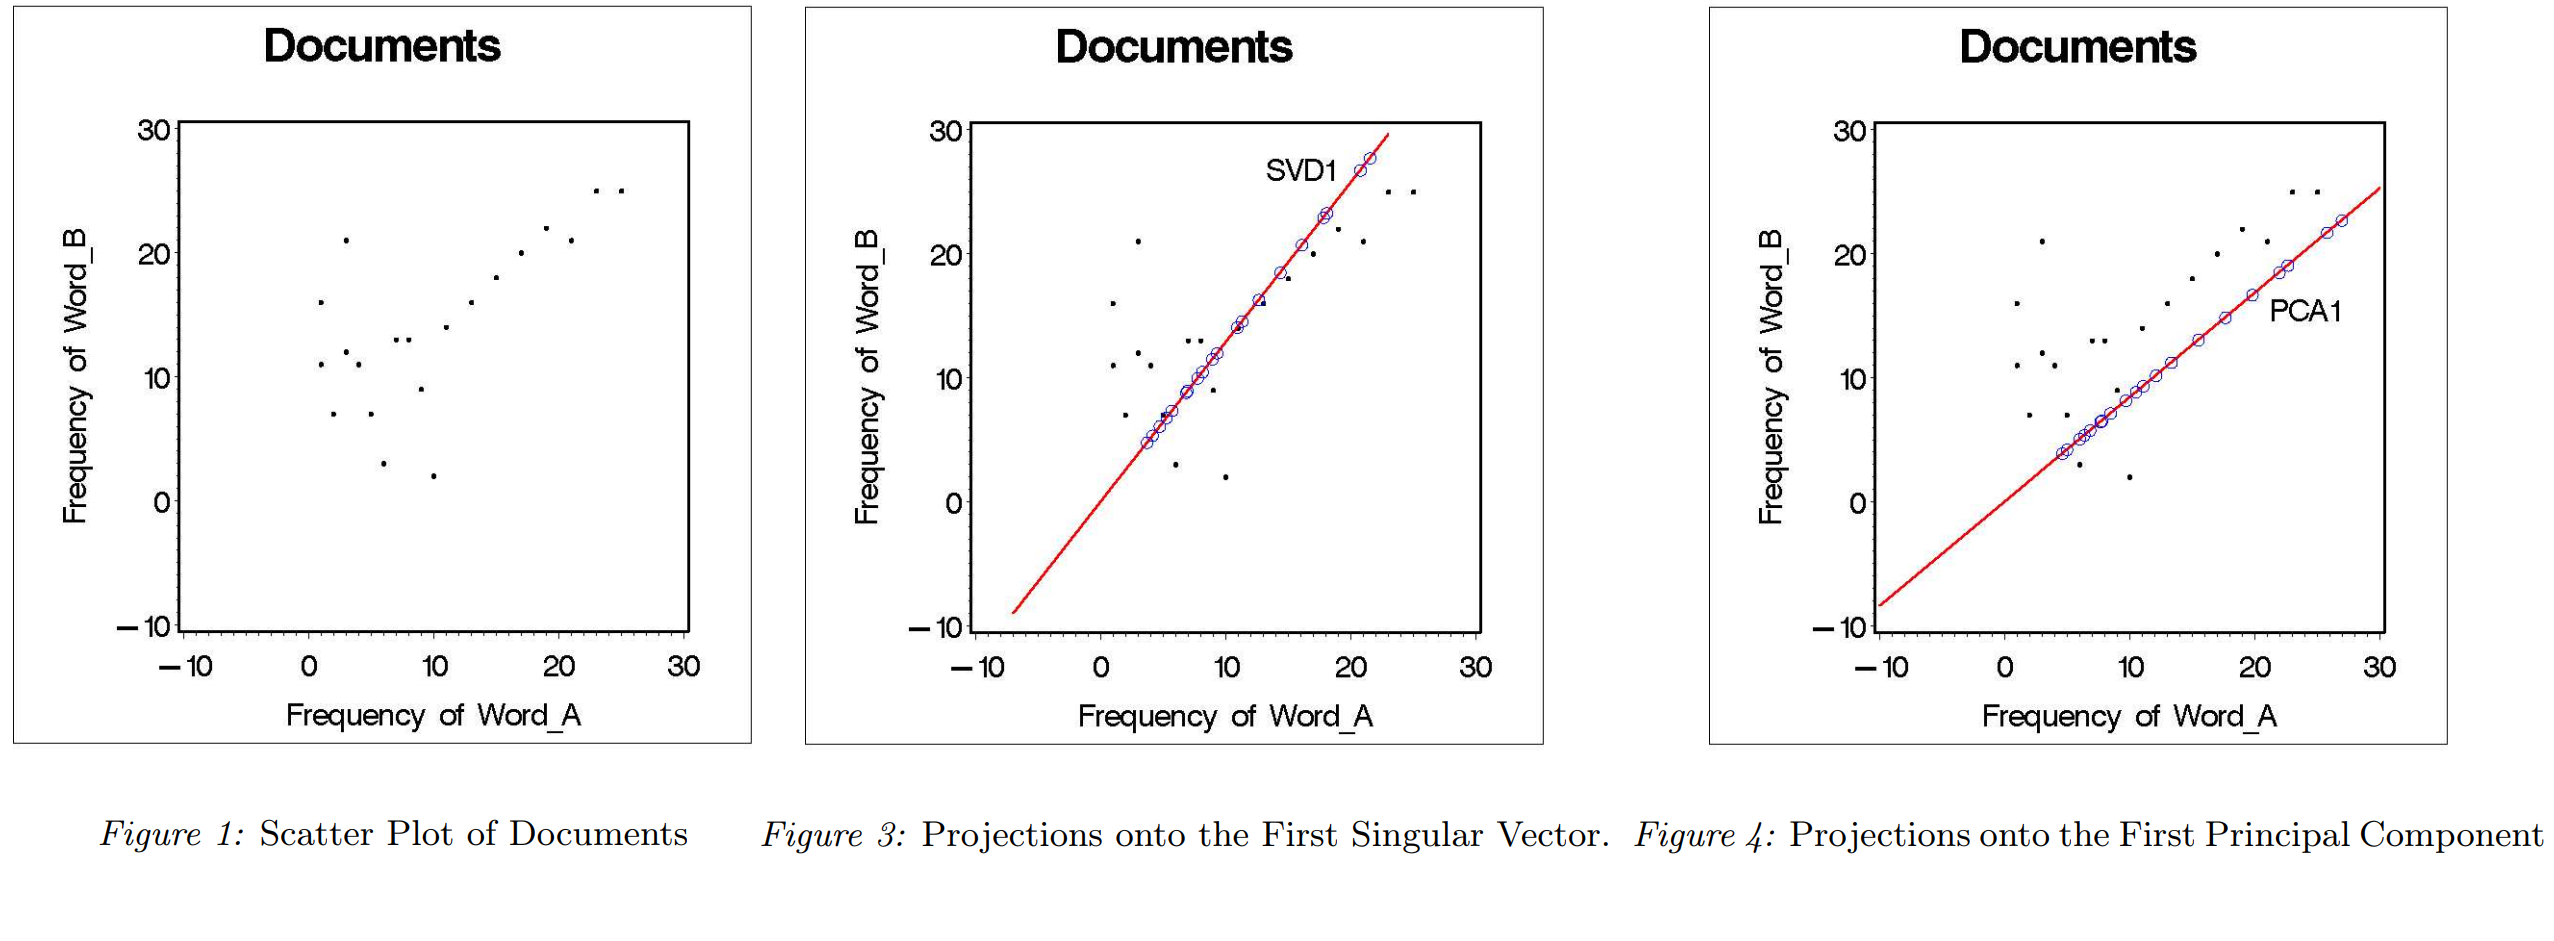

In [44]:
# SVD vs PCA
Image("../../raw_data/images/svd_vs_pca.png", width=1000)

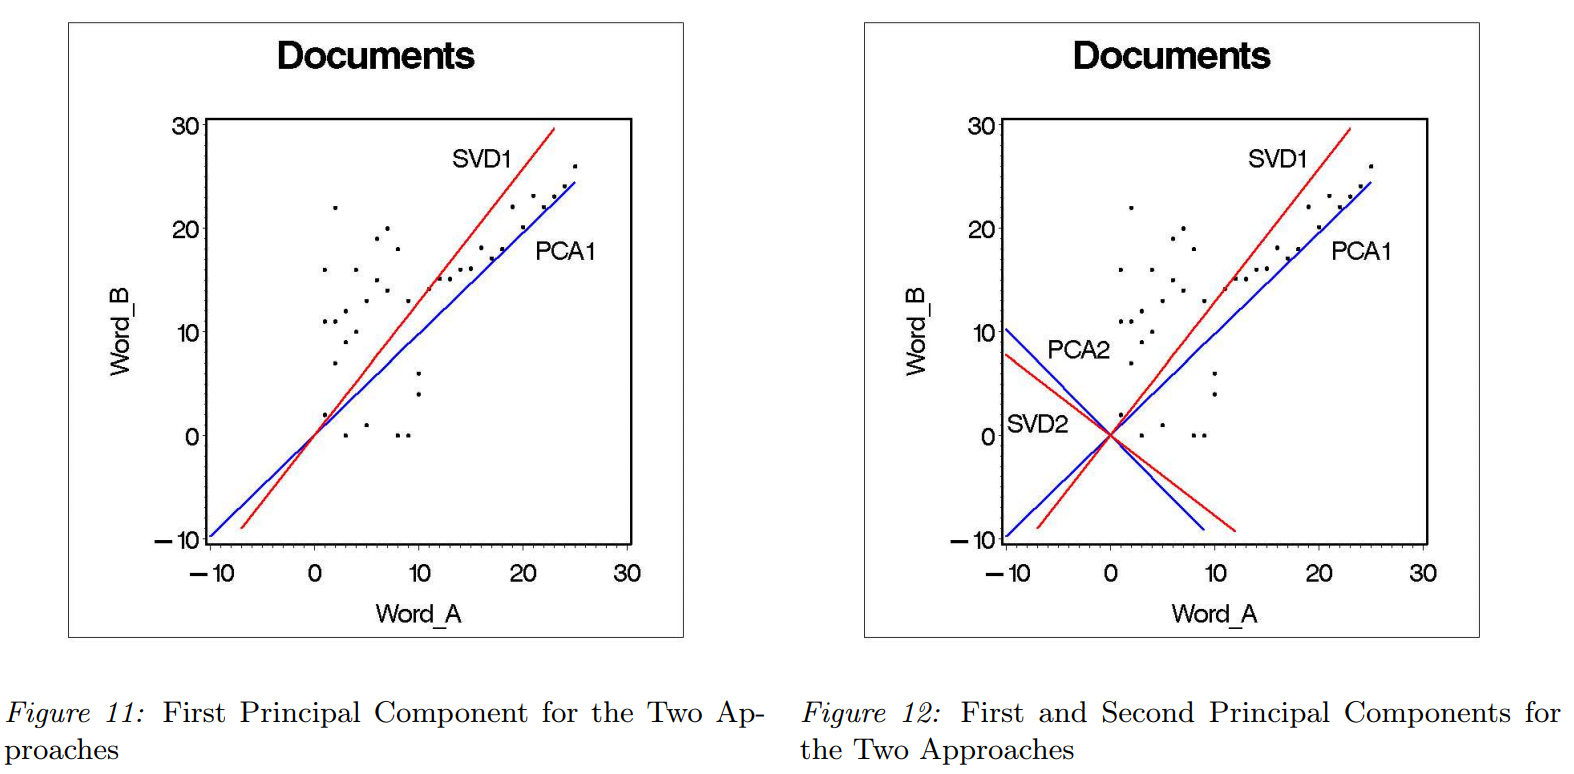

In [45]:
# SVD vs PCA
Image("../../raw_data/images/svd_vs_pca2.png", width=700)

### Latent Semantic Indexing (LSI)
Latent semantic indexing (LSI) is an indexing and retrieval method that uses a mathematical technique called singular value decomposition (SVD) to identify patterns in the relationships between the terms and concepts contained in an unstructured collection of text. LSI is based on the principle that words that are used in the same contexts tend to have similar meanings. A key feature of LSI is its ability to extract the conceptual content of a body of text by establishing associations between those terms that occur in similar contexts.

The method, also called latent semantic analysis (LSA), uncovers the underlying latent semantic structure in the usage of words in a body of text and how it can be used to extract the meaning of the text in response to user queries, commonly referred to as concept searches. Queries, or concept searches, against a set of documents that have undergone LSI will return results that are conceptually similar in meaning to the search criteria even if the results don’t share a specific word or words with the search criteria.

##### Overview
LSA can use a term-document matrix which describes the occurrences of terms in documents; it is a sparse matrix whose rows correspond to terms and whose columns correspond to documents. A typical example of the weighting of the elements of the matrix is tf-idf (term frequency–inverse document frequency): the weight of an element of the matrix is proportional to the number of times the terms appear in each document, where rare terms are upweighted to reflect their relative importance.

This matrix is also common to standard semantic models, though it is not necessarily explicitly expressed as a matrix, since the mathematical properties of matrices are not always used.

##### Rank Lowering
After the construction of the occurrence matrix, LSA finds a low-rank approximation to the term-document matrix. There could be various reasons for these approximations:

**The original term-document matrix is presumed too large for the computing resources:** in this case, the approximated low rank matrix is interpreted as an approximation (a "least and necessary evil").
**The original term-document matrix is presumed noisy:** for example, anecdotal instances of terms are to be eliminated. From this point of view, the approximated matrix is interpreted as a de-noisified matrix (a better matrix than the original).
The original term-document matrix is presumed overly sparse relative to the "true" term-document matrix. That is, the original matrix lists only the words actually in each document, whereas we might be interested in all words related to each document—generally a much larger set due to synonymy.
The consequence of the rank lowering is that some dimensions are combined and depend on more than one term:

{(car), (truck), (flower)} --> {(1.3452 * car + 0.2828 * truck), (flower)}

This mitigates the problem of identifying synonymy, as the rank lowering is expected to merge the dimensions associated with terms that have similar meanings. It also mitigates the problem with polysemy, since components of polysemous words that point in the "right" direction are added to the components of words that share a similar meaning. Conversely, components that point in other directions tend to either simply cancel out, or, at worst, to be smaller than components in the directions corresponding to the intended sense.


##### Use Cases
- Compare the documents in the low-dimensional space (data clustering, document classification).
- Find similar documents across languages, after analyzing a base set of translated documents (cross language retrieval).
- Find relations between terms (synonymy and polysemy).
- Given a query of terms, translate it into the low-dimensional space, and find matching documents (information retrieval).
- Find the best similarity between small groups of terms, in a semantic way (i.e. in a context of a knowledge corpus), as for example in multi choice questions MCQ answering model.
- Expand the feature space of machine learning / text mining systems 
- Analyze word association in text corpus 

Synonymy and polysemy are fundamental problems in natural language processing:
* **Synonymy** is the phenomenon where different words describe the same idea. Thus, a query in a search engine may fail to retrieve a relevant document that does not contain the words which appeared in the query. For example, a search for "doctors" may not return a document containing the word "physicians", even though the words have the same meaning.

* **Polysemy** is the phenomenon where the same word has multiple meanings. So a search may retrieve irrelevant documents containing the desired words in the wrong meaning. For example, a botanist and a computer scientist looking for the word "tree" probably desire different sets of documents.

##### Limitations
LSA cannot capture polysemy (i.e., multiple meanings of a word) because each occurrence of a word is treated as having the same meaning due to the word being represented as a single point in space. For example, the occurrence of "chair" in a document containing "The Chair of the Board" and in a separate document containing "the chair maker" are considered the same. The behavior results in the vector representation being an average of all the word's different meanings in the corpus, which can make it difficult for comparison. However, the effect is often lessened due to words having a predominant sense throughout a corpus (i.e. not all meanings are equally likely).

SOURCE: https://en.wikipedia.org/wiki/Latent_semantic_analysis#cite_note-38

In [46]:
from sklearn.decomposition import TruncatedSVD

In [47]:
svd_data[0]

'unlike many of our competitor we do not charge a rebook or exchange fee for customers who change their itinerary nor have we ever require a saturday night stay'

In [48]:
# vectorize the text with TFIDF
vect = TfidfVectorizer(max_features=10)
fit_vect = vect.fit_transform(svd_data)
pd.DataFrame(fit_vect.toarray(), columns=vect.get_feature_names())

,1_quarter,and,company,fee,for,from,in,of,the,to
0,0.000000,0.000000,0.000000,0.466317,0.586332,0.000000,0.000000,0.662393,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.312829,0.000000,0.506816,0.000000,0.000000,0.700399,0.393341
2,0.820339,0.230216,0.000000,0.000000,0.230216,0.000000,0.000000,0.000000,0.409932,0.230216
3,0.000000,0.292166,0.436257,0.697090,0.292166,0.000000,0.000000,0.000000,0.260122,0.292166
4,0.000000,0.822774,0.000000,0.327181,0.000000,0.000000,0.000000,0.464753,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.268932,0.676293,0.435699,0.435699,0.000000,0.301059,0.000000
6,0.000000,0.470357,0.351163,0.187040,0.235178,0.303025,0.303025,0.531373,0.209384,0.235178
7,0.000000,0.238362,0.000000,0.379144,0.000000,0.000000,0.307127,0.269283,0.636655,0.476723


Dimensionality reduction using TruncatedSVD (aka LSA).

This transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with scipy.sparse matrices efficiently.

In particular, truncated SVD works on term count/tf-idf matrices as returned by the vectorizers in sklearn.feature_extraction.text. In that context, it is known as latent semantic analysis (LSA).

SOURCE: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

In [49]:
tsvd = TruncatedSVD(n_components=2)
tsvd.fit_transform(fit_vect)

array([[ 0.64816202,  0.46931288],
       [ 0.6912436 , -0.59083523],
       [ 0.49328143, -0.39913471],
       [ 0.80908669,  0.0419023 ],
       [ 0.60860387,  0.60989328],
       [ 0.67566566, -0.20503142],
       [ 0.86696506,  0.26400541],
       [ 0.84569481, -0.22978827]])

# LDA/NMF

The normal distribution is a probability distribution over all the real numbers. It is described by a mean and a variance. The mean is the expected value of this distribution, and the variance tells us how much we can expect samples to deviate from the mean. If the variance is very high, then you’re going to see values that are both much smaller than the mean and much larger than the mean. If the variance is small, then the samples will be very close to the mean. If the variance goes close to zero, all samples will be almost exactly at the mean.

The dirichlet distribution is a probability distribution as well - but it is not sampling from the space of real numbers. Instead it is sampling over a probability simplex.

And what is a probability simplex? It’s a bunch of numbers that add up to 1. For example:

- (0.6, 0.4)
- (0.1, 0.1, 0.8)
- (0.05, 0.2, 0.15, 0.1, 0.3, 0.2)

These numbers represent probabilities over K distinct categories. In the above examples, K is 2, 3, and 6 respectively. That’s why they are also called categorical distributions.

When we are dealing with categorical distributions and we have some uncertainty over what that distribution is, simplest way to represent that uncertainty as a probability distribution is the Dirichlet.

SOURCE: 
- [What is an intuitive explanation of the Dirichlet distribution?](https://www.quora.com/What-is-an-intuitive-explanation-of-the-Dirichlet-distribution)
- [VIDEO: Digging into the Dirichlet Distribution](https://www.hakkalabs.co/articles/the-dirichlet-distribution)
- [Introduction to Latent Dirichlet Allocation:](http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/)

In [55]:
from gensim.models.ldamodel import LdaModel

In [56]:
ldamodel = LdaModel(
      tfidf_vect
    , num_topics=10
    , id2word=dictionary
    , passes=200
)

In [57]:
ldamodel.print_topics(num_topics=10, num_words=5)

[(0,
  '0.009*"annum" + 0.009*"commitment" + 0.008*"congress" + 0.008*"credit" + 0.007*"june"'),
 (1,
  '0.009*"change_seat" + 0.009*"item_such_a_1" + 0.008*"2_check" + 0.008*"telephone_reservation" + 0.008*"major_competitor"'),
 (2,
  '0.011*"these" + 0.011*"taxis_and_fee" + 0.007*"mishandle" + 0.007*"wheelchair" + 0.006*"federal_transportation"'),
 (3,
  '0.018*"million_or_percent" + 0.008*"numb_of_total" + 0.008*"few" + 0.008*"cost_be_then_allocate" + 0.008*"among"'),
 (4,
  '0.015*"fee_and_other_rental" + 0.015*"expect_landing" + 0.013*"company_currently" + 0.012*"available_seat_mile" + 0.007*"rule"'),
 (5,
  '0.007*"approximately_percent" + 0.007*"consolidate" + 0.007*"rental" + 0.007*"consolidated_statement" + 0.007*"rental_respectively"'),
 (6,
  '0.016*"approximately_million" + 0.016*"dollar_basis" + 0.015*"rental" + 0.013*"flat_compare" + 0.012*"follow_the_acquisition"'),
 (7,
  '0.017*"airline_that_doe" + 0.014*"customer_change" + 0.014*"conjurer_the_only_major" + 0.010*"impo

### pyLDAvis

**conda install pyldavis**

pyLDAvis is a python libarary for interactive topic model visualization. It is a port of the fabulous R package by Carson Sievert and Kenny Shirley. They did the hard work of crafting an effective visualization. pyLDAvis makes it easy to use the visualiziation from Python and, in particualr, IPython notebooks. To learn more about the method behind the visualization I suggest reading the original paper explaining it.

- Larger topics are more frequent in the corpus.
- Topics closer together are more similar, topics further apart are less similar.
- When you select a topic, you can see the most representative words for the selected topic. This measure can be a combination of how frequent or how discriminant the word is. You can adjust the weight of each property using the slider.
- Hovering over a word will adjust the topic sizes according to how representative the word is for the topic.

SOURCE:
- [Complete Guide to Topic Modeling](https://nlpforhackers.io/topic-modeling/)

In [58]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, mds='tsne')

C:\Users\alsherman\AppData\Local\Continuum\anaconda3\envs\guild\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics          x          y
topic                                                  
4      15.778257        1       1   4.983401 -89.317520
2      12.242445        1       2 -24.079443  13.263611
1      11.847339        1       3 -62.045834  54.260960
0      10.801965        1       4  20.740929 -18.464249
5       9.672136        1       5 -29.233168 -41.434349
8       9.649071        1       6  64.324654  18.158342
6       9.010195        1       7  12.726865  58.049213
7       8.640659        1       8  62.430889 -56.796928
9       7.139094        1       9 -84.135422 -11.365413
3       5.218844        1      10 -68.847420 -80.641914, topic_info=     Category      Freq                     Term     Total  loglift  logprob
term                                                                        
188   Default  4.000000       million_or_percent  4.000000  30.0000  30.0000
768   Default  4.000000         airline_that_doe  4.000000  29.0000  29.0000
867   Default  6.000000                   rental  6.000000  28.0000  28.0000
845   Default  5.000000    approximately_million  5.000000  27.0000  27.0000
155   Default  7.000000     fee_and_other_rental  7.000000  26.0000  26.0000
980   Default  7.000000           expect_landing  7.000000  25.0000  25.0000
207   Default  5.000000             dollar_basis  5.000000  24.0000  24.0000
762   Default  4.000000  conjurer_the_only_major  4.000000  23.0000  23.0000
586   Default  4.000000          customer_change  4.000000  22.0000  22.0000
116   Default  4.000000             flat_compare  4.000000  21.0000  21.0000
960   Default  4.000000   follow_the_acquisition  4.000000  20.0000  20.0000
512   Default  4.000000                     year  4.000000  19.0000  19.0000
644   Default  7.000000        company_currently  7.000000  18.0000  18.0000
581   Default  5.000000        aviation_security  5.000000  17.0000  17.0000
502   Default  5.000000            taxis_and_fee  5.000000  16.0000  16.0000
852   Default  5.000000                    these  5.000000  15.0000  15.0000
361   Default  7.000000      available_seat_mile  7.000000  14.0000  14.0000
880   Default  4.000000                   impose  4.000000  13.0000  13.0000
376   Default  3.000000              integration  3.000000  12.0000  12.0000
820   Default  5.000000                  collect  5.000000  11.0000  11.0000
969   Default  4.000000                     rate  4.000000  10.0000  10.0000
914   Default  4.000000    telephone_reservation  4.000000   9.0000   9.0000
905   Default  4.000000              change_seat  4.000000   8.0000   8.0000
682   Default  4.000000            item_such_a_1  4.000000   7.0000   7.0000
253   Default  3.000000                excluding  3.000000   6.0000   6.0000
778   Default  4.000000                   period  4.000000   5.0000   5.0000
589   Default  3.000000                    annum  3.000000   4.0000   4.0000
500   Default  3.000000               commitment  3.000000   3.0000   3.0000
334   Default  3.000000                     plan  3.000000   2.0000   2.0000
982   Default  2.000000            numb_of_total  2.000000   1.0000   1.0000
...       ...       ...                      ...       ...      ...      ...
896   Topic10  0.745517                baltimore  2.116773   1.9093  -5.1584
929   Topic10  0.745517               washington  2.116773   1.9093  -5.1584
310   Topic10  0.745517                  chicago  2.116773   1.9093  -5.1584
702   Topic10  0.745517                   midway  2.116773   1.9093  -5.1584
13    Topic10  1.011545            increase_land  2.905466   1.8978  -4.8533
354   Topic10  0.920738        customer_friendly  2.667344   1.8892  -4.9473
45    Topic10  0.674581                reduction  2.045836   1.8434  -5.2584
370   Topic10  0.674581                  overall  2.045836   1.8434  -5.2584
17    Topic10  0.652259          percent_compare  2.023747   1.8206  -5.2920
746   Topic10  0.590949     violation_of_section  1

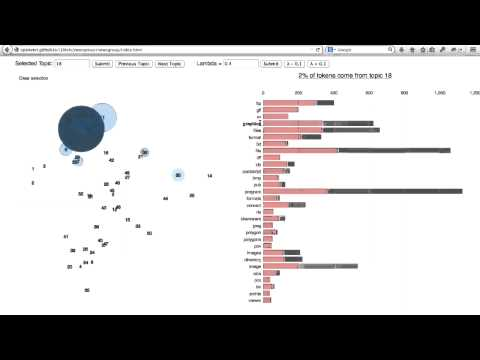

In [54]:
YouTubeVideo('IksL96ls4o0', width=800, height=400)

## Visdom

Install it with:

`conda install visdom`

Start the server:

`python -m visdom.server`

Visdom now can be accessed at http://localhost:8097 in the browser.


##### METRICS:
**DiffMetric** calculates the distance between two LDA models. This distance is calculated based on the topics, by either using their probability distribution over vocabulary words (**kullback_leibler**, hellinger) or by simply using the common vocabulary words between the topics from both model.

In the heatmap, X-axis define the Epoch no. and Y-axis define the distance between identical topics from consecutive epochs. For ex. a particular cell in the heatmap with values (x=3, y=5, z=0.4) represent the distance(=0.4) between the topic 5 from 3rd epoch and topic 5 from 2nd epoch. With increasing epochs, the distance between the identical topics should decrease.

SOURCE: 
- [LDA Training Visualization](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/Training_visualizations.ipynb)
- [Visdom](https://github.com/facebookresearch/visdom)
- [Training and Topic visualizations in gensim](https://rare-technologies.com/paruls-gsoc-2017-summary-training-and-topic-visualizations-in-gensim/)
- [OptimizingSemanticCoherenceinTopicModels](https://people.cs.umass.edu/~wallach/publications/mimno11optimizing.pdf)

In [73]:
from gensim.models.callbacks import DiffMetric

# define kullback_leibler callback
diff_kl = DiffMetric(distance="kullback_leibler", logger="visdom", title="Diff (kullback_leibler)")

# training LDA model
ldamodel = LdaModel(
      tfidf_vect
    , num_topics=20
    , id2word=dictionary
    , passes=180
    , callbacks=[diff_kl]
)

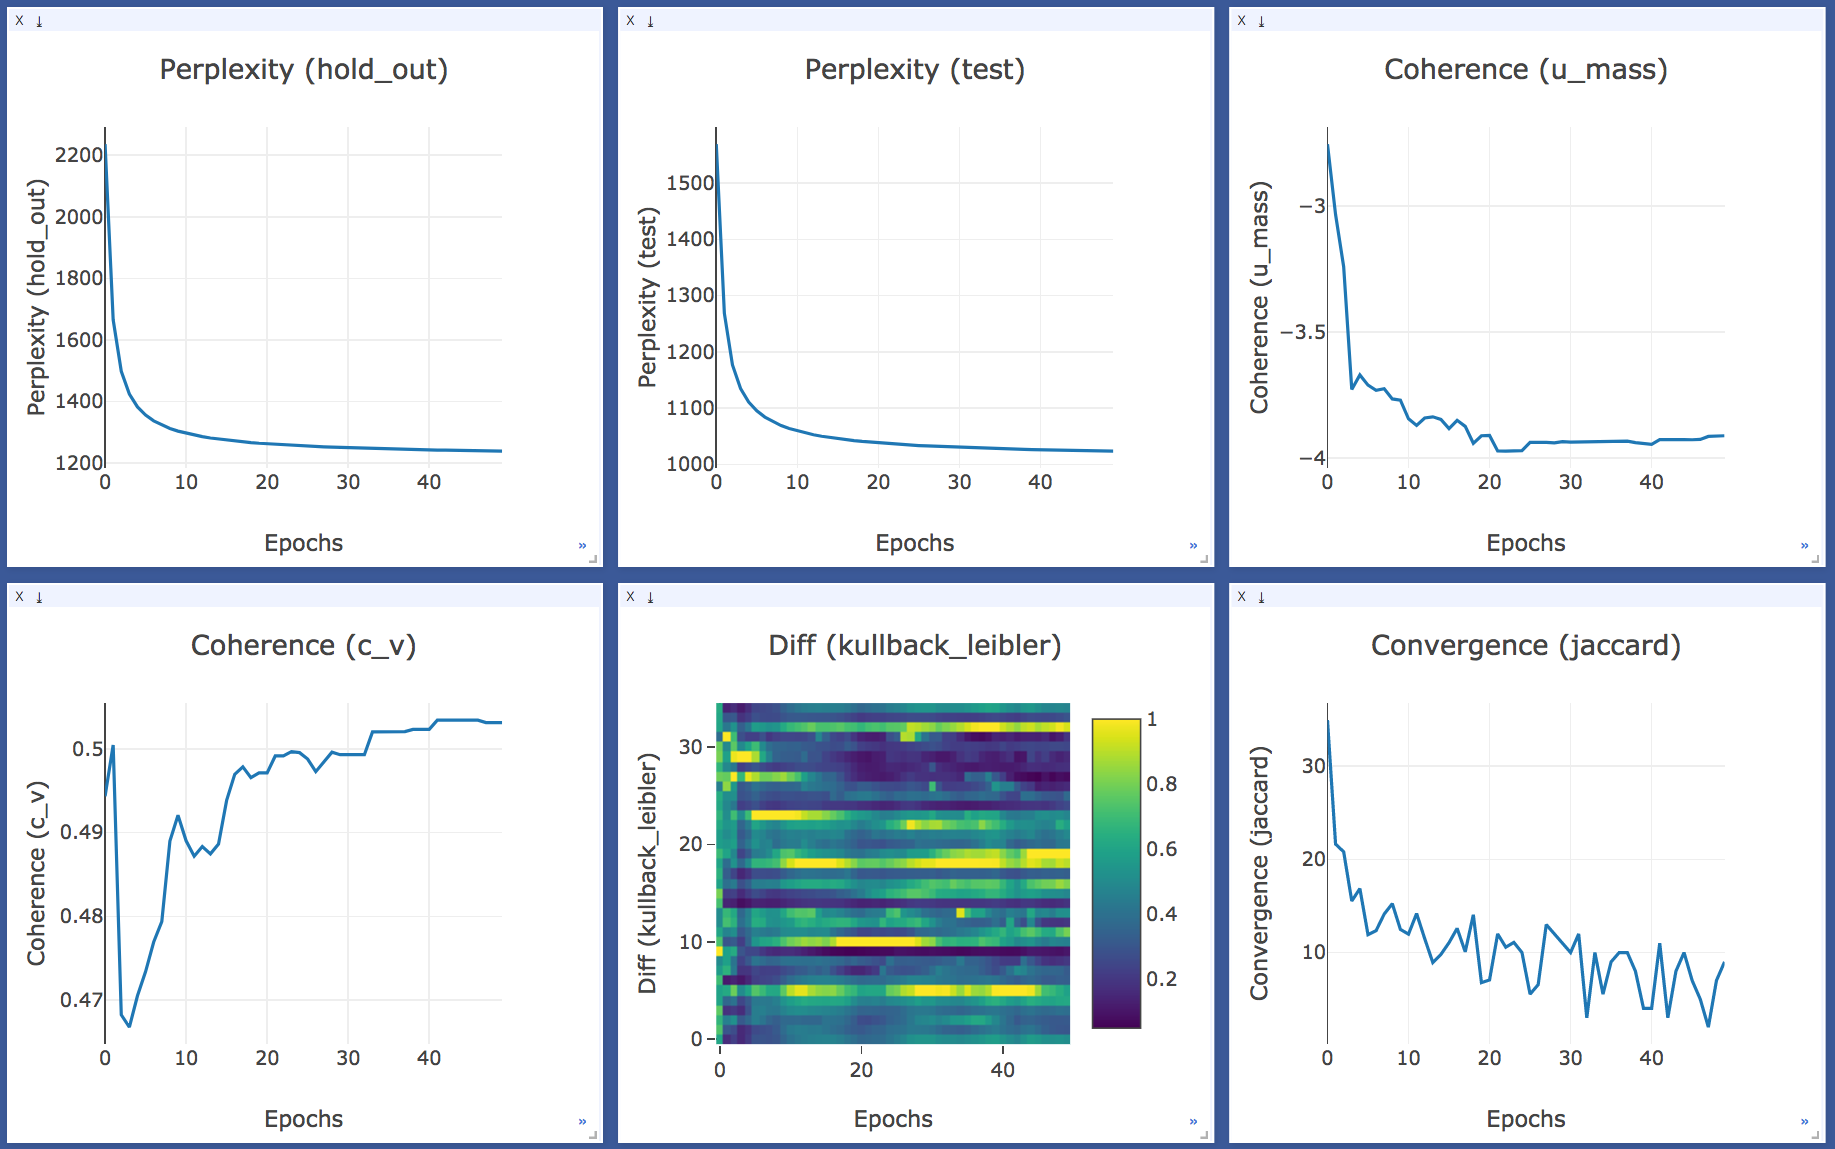

In [57]:
# visdom UI
Image("../../raw_data/images/visdom_graph.png", width=800)

### Word2Vec

##### There are many things you can do to capture similarity:
- Query expansion with synonym dictionaries
- Separately learning word similarities from large corpora
- Encode similarity

##### Why do we need Word Embeddings?
"Many machine learning algorithms and almost all Deep Learning Architectures are incapable of processing strings or plain text in their raw form. They require numbers as inputs to perform any sort of job, be it classification, regression etc. in broad terms. And with the huge amount of data that is present in the text format, it is imperative to extract knowledge out of it and build applications."

"So a natural language modelling technique like Word Embedding is used to map words or phrases from a vocabulary to a corresponding vector of real numbers. As well as being amenable to processing by ML algorithms, this vector representation has two important and advantageous properties:

- **Dimensionality Reduction** - it is a more efficient representation
- **Contextual Similarity** - it is a more expressive representation"


##### Techniques (Count versus Predictive)
Count-based methods compute the statistics of how often some word co-occurs with its neighbor words in a large text corpus, and then map these count-statistics down to a small, dense vector for each word. Predictive models directly try to predict a word from its neighbors in terms of learned small, dense embedding vectors (considered parameters of the model)."


##### Improvement over other methods 

Word embeddings are an improvement over simpler bag-of-word model word encoding schemes like word counts and frequencies that result in large and sparse vectors (mostly 0 values) that describe documents but not the meaning of the words.

Word embeddings work by using an algorithm to train a set of fixed-length dense and continuous-valued vectors based on a large corpus of text. Each word is represented by a point in the embedding space and these points are learned and moved around based on the words that surround the target word.

It is defining a word by the company that it keeps that allows the word embedding to learn something about the meaning of words. The vector space representation of the words provides a projection where words with similar meanings are locally clustered within the space.

The use of word embeddings over other text representations is one of the key methods that has led to breakthrough performance with deep neural networks on problems like machine translation.


SOURCE: 
- [An Intuitive Understanding of Word Embeddings: From Count Vectors to Word2Vec](https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/)
- [What is word embedding in deep learning?](https://www.quora.com/What-is-word-embedding-in-deep-learning)
- [Representations for Language: From Word Embeddings to Sentence Meanings
](https://nlp.stanford.edu/manning/talks/Simons-Institute-Manning-2017.pdf)
- [How to Develop Word Embeddings in Python with Gensim](https://machinelearningmastery.com/develop-word-embeddings-python-gensim/)

In [60]:
from gensim.models import word2vec

corpus = [
          'Text of the first document.',
          'Text of the second document made longer.',
          'Number three.',
          'This is number four.',
]

# we need to pass splitted sentences to the model
tokenized_sentences = [sentence.split() for sentence in corpus]
tokenized_sentences

[['Text', 'of', 'the', 'first', 'document.'],
 ['Text', 'of', 'the', 'second', 'document', 'made', 'longer.'],
 ['Number', 'three.'],
 ['This', 'is', 'number', 'four.']]

### word2Vec Hyperparameters

- **size:** (default 100) The number of dimensions of the embedding, e.g. the length of the dense vector to represent each token (word).
- **window:** (default 5) The maximum distance between a target word and words around the target word.
- **min_count:** (default 5) The minimum count of words to consider when training the model; words with an occurrence less than this count will be ignored.
- **workers:** (default 3) The number of threads to use while training.
- **sg:** (default 0 or CBOW) The training algorithm, either CBOW (0) or skip gram (1).

In [61]:
model = word2vec.Word2Vec(
      sentences=tokenized_sentences
    , size=10
    , window=5
    , min_count=1
    , sg=0
)

print(model)

Word2Vec(vocab=15, size=10, alpha=0.025)


In [62]:
print(list(model.wv.vocab))

['the', 'three.', 'first', 'Text', 'This', 'second', 'longer.', 'made', 'four.', 'of', 'document.', 'is', 'document', 'Number', 'number']


In [63]:
# create a word vector from a trained work
print(model.wv['Text'])

[ 0.0315959   0.00212805 -0.01174479 -0.02416784  0.01268861 -0.00797676
  0.03163143 -0.00580039 -0.04658512  0.02172104]


In [66]:
# a trained model can then be saved to file
model.wv.save_word2vec_format('model.bin')

In [69]:
# The pre-trained Word2Vec model can then be loaded again
model = gensim.models.KeyedVectors.load_word2vec_format('model.bin')
print(model)

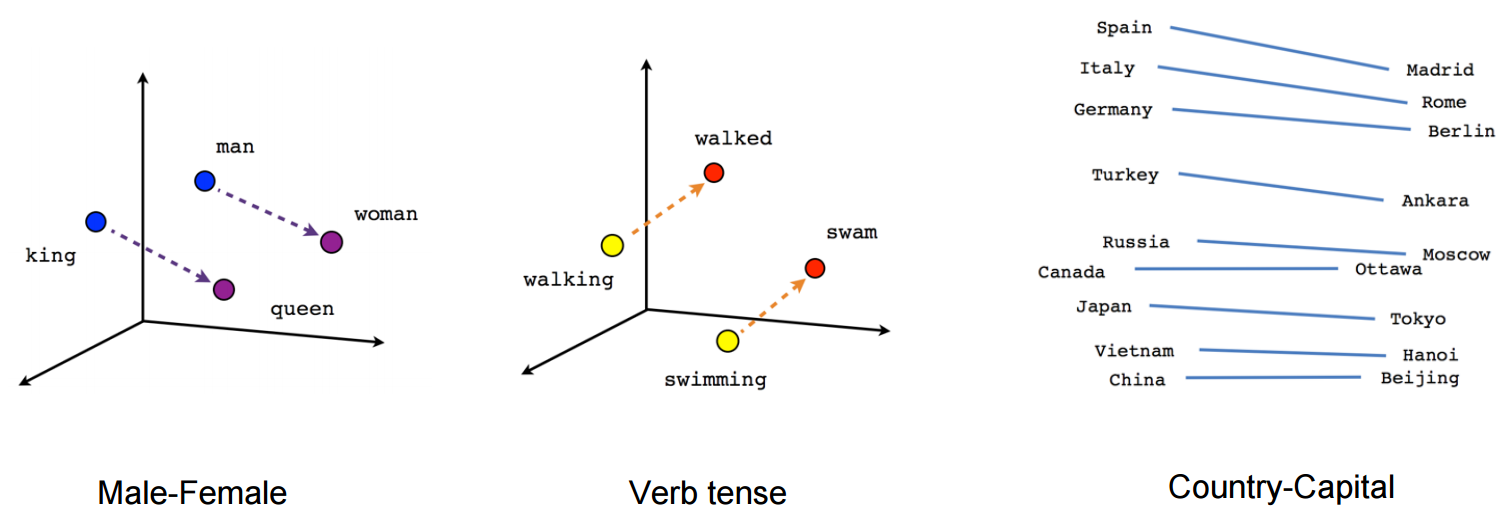

In [72]:
# Document and Word Vectors
Image("../../raw_data/images/man_to_king_w2v.png", width=800)

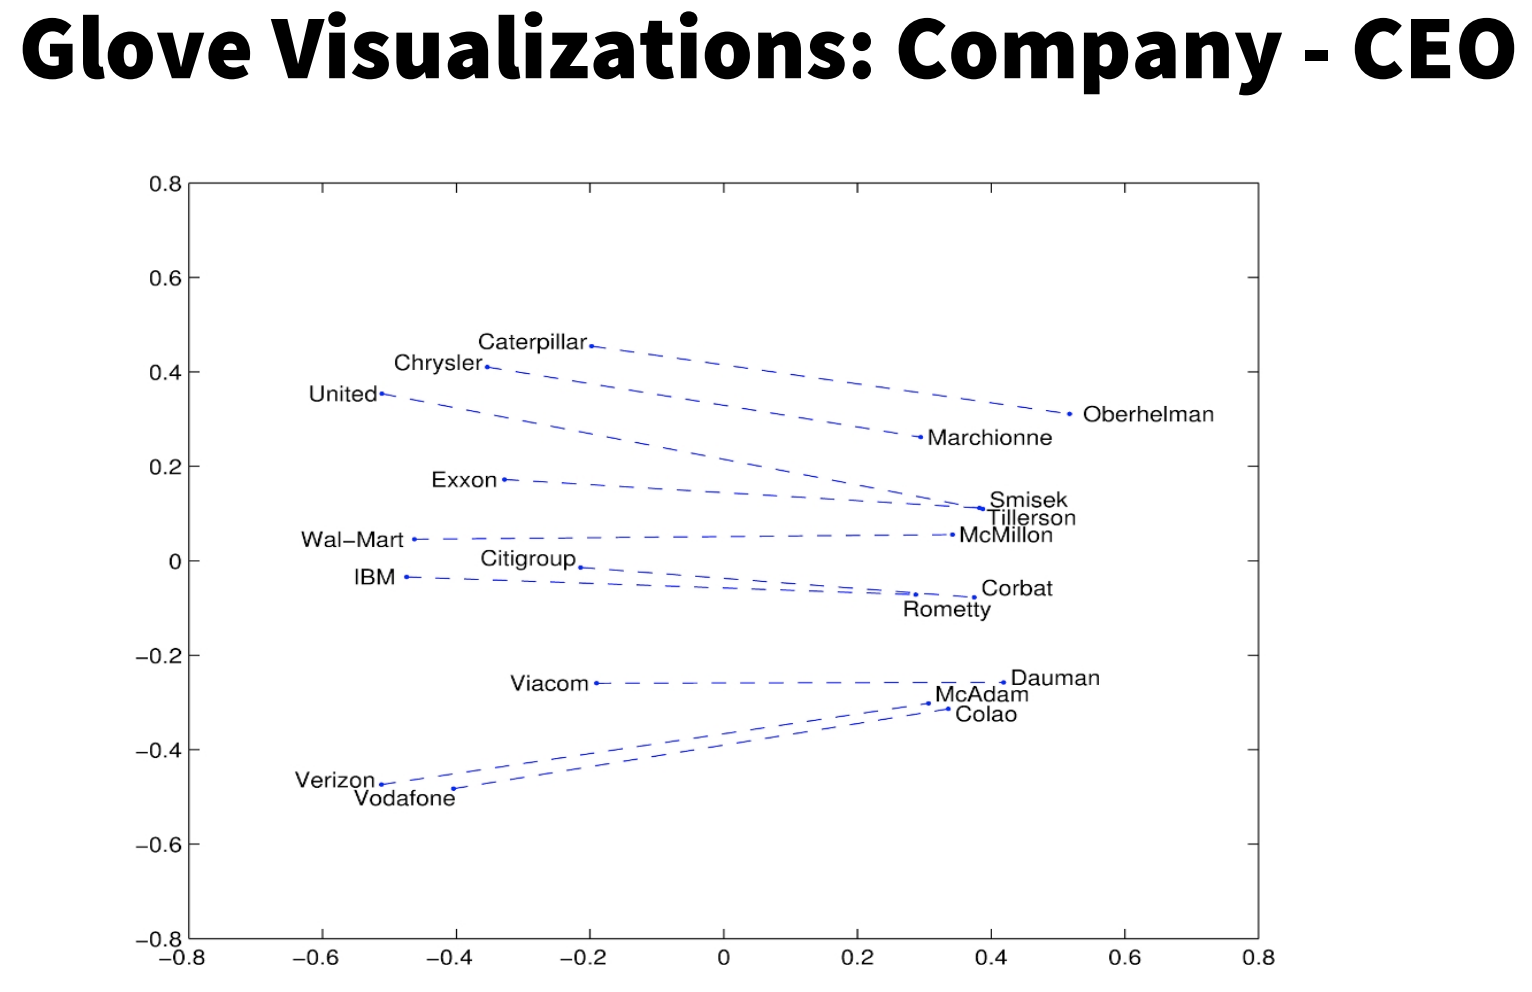

In [114]:
# GloVe Visual 
Image("../../raw_data/images/glove_visualizations.png", width=800)

### CBOW and skip-gram

Word2Vec uses a trick you may have seen elsewhere in machine learning. We’re going to train a simple neural network with a single hidden layer to perform a certain task, but then we’re not actually going to use that neural network for the task we trained it on! Instead, the goal is actually just to learn the weights of the hidden layer–we’ll see that these weights are actually the “word vectors” that we’re trying to learn.

The network is going to learn the statistics from the number of times each pairing shows up. So, for example, the network is probably going to get many more training samples of (“Soviet”, “Union”) than it is of (“Soviet”, “Sasquatch”). When the training is finished, if you give it the word “Soviet” as input, then it will output a much higher probability for “Union” or “Russia” than it will for “Sasquatch”.

"Word2vec is a particularly computationally-efficient predictive model for learning word embeddings from raw text. It comes in two flavors, the Continuous Bag-of-Words model (CBOW) and the Skip-Gram model (Section 3.1 and 3.2 in Mikolov et al.). Algorithmically, these models are similar, except that CBOW predicts target words (e.g. 'mat') from source context words ('the cat sits on the'), while the skip-gram does the inverse and predicts source context-words from the target words. This inversion might seem like an arbitrary choice, but statistically it has the effect that CBOW smoothes over a lot of the distributional information (by treating an entire context as one observation). For the most part, this turns out to be a useful thing for smaller datasets. However, skip-gram treats each context-target pair as a new observation, and this tends to do better when we have larger datasets. We will focus on the skip-gram model in the rest of this tutorial."

A standard approach for learning word representations is to train log-bilinear models based on either the skip-gram or the continuous bag-of-words (cbow) architectures, as implemented in word2vec (Mikolov et al., 2013a) and fastText (Bojanowski et al., 2017)1 . In the skip-gram model, nearby words are predicted given a source word, while in the cbow model, the source word is predicted according to its context. These architectures and their implementation have been optimized to produce high quality word representations able to transfer to many tasks, while maintaining a sufficiently

SOURCE: 
- [Advances in Pre-Training Distributed Word Representations](https://arxiv.org/pdf/1712.09405.pdf)
- [Vector Representations of Words](https://www.tensorflow.org/tutorials/word2vec)
- [Word2Vec Tutorial - The Skip-Gram Model](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)

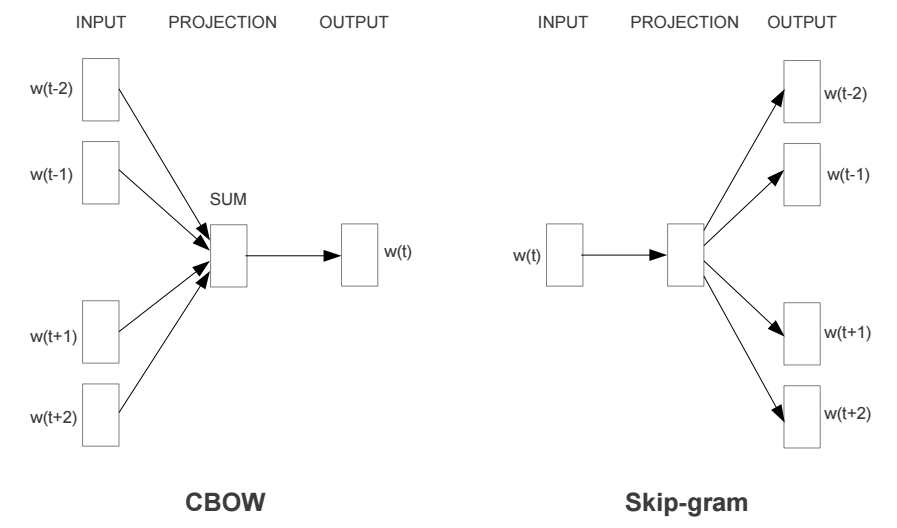

In [73]:
# Document and Word Vectors
Image("../../raw_data/images/word2vec_approaches.png", width=400)

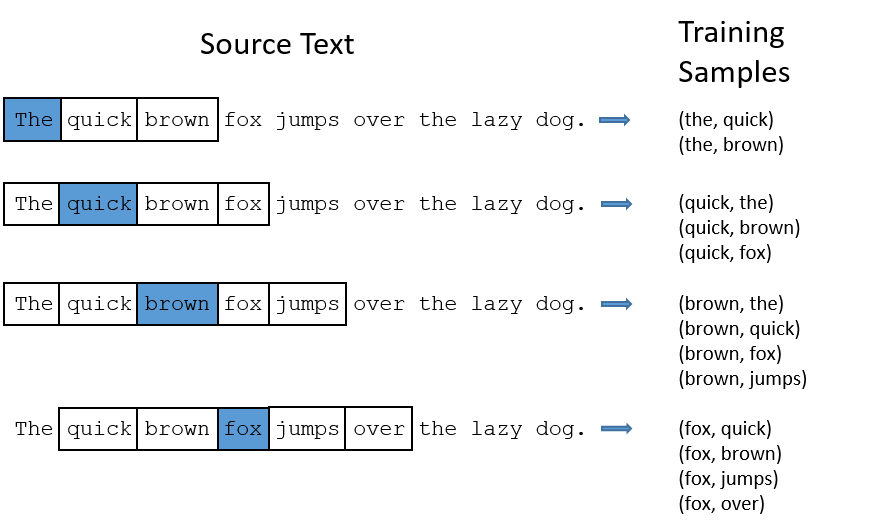

In [122]:
# Word2Vec Window
Image("../../raw_data/images/w2v_window.png", width=600)

##### Input
When training this network on word pairs, the input is a one-hot vector representing the input word and the training output is also a one-hot vector representing the output word. But when you evaluate the trained network on an input word, the output vector will actually be a probability distribution (i.e., a bunch of floating point values, not a one-hot vector).

##### The Hidden Layer
For our example, we’re going to say that we’re learning word vectors with 300 features. So the hidden layer is going to be represented by a weight matrix with 10,000 rows (one for every word in our vocabulary) and 300 columns (one for every hidden neuron).

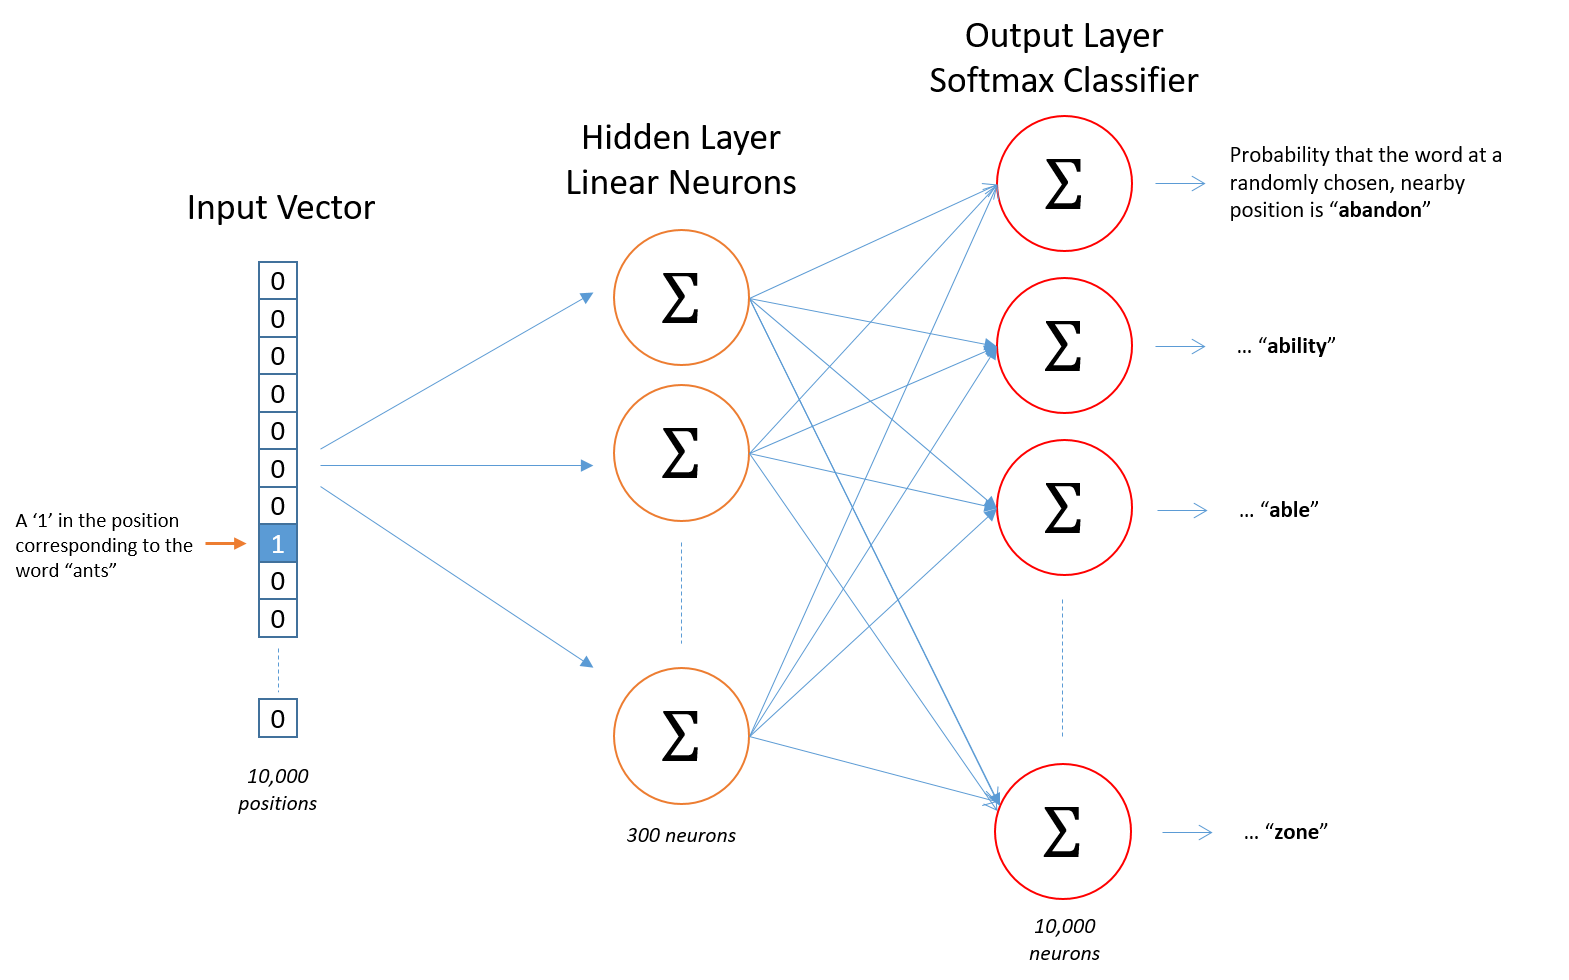

In [123]:
# Word2Vec Architecture
Image("../../raw_data/images/w2v_architecture.png", width=400)

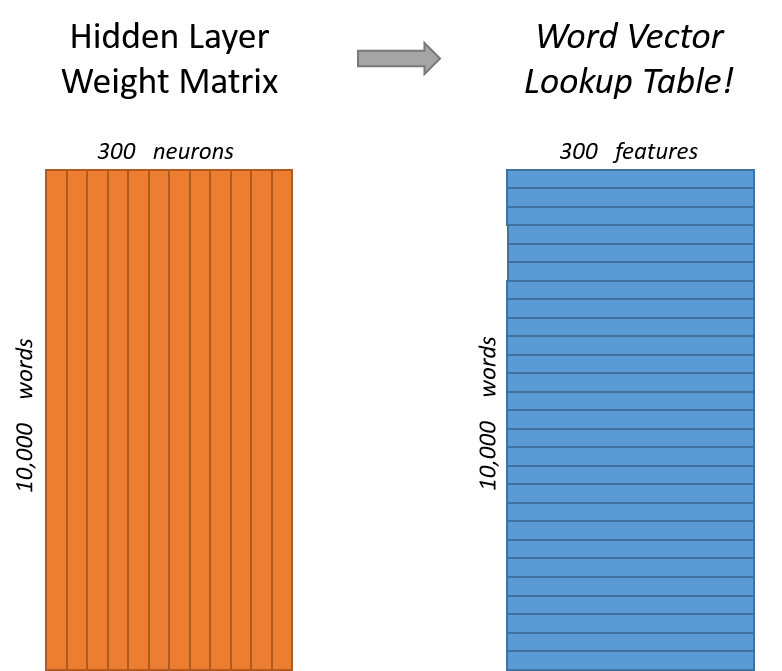

In [76]:
# Word2Vec Hidden Layer
Image("../../raw_data/images/word2vec_hidden_layer.png", width=400)

There are three innovations in this second paper:

- Treating common word pairs or phrases as single “words” in their model.
- Subsampling frequent words to decrease the number of training examples.
- Modifying the optimization objective with a technique they called “Negative Sampling”, which causes each training sample to update only a small percentage of the model’s weights.

##### Phrases
Each passonly looks at combinations of 2 words, but you can run it multiple times to get longer phrases. So, the first pass will pick up the phrase “New_York”, and then running it again will pick up “New_York_City” as a combination of “New_York” and “City”.

##### Subsampling
Word2Vec implements a “subsampling” scheme to address this. For each word we encounter in our training text, there is a chance that we will effectively delete it from the text. The probability that we cut the word is related to the word’s frequency.

If we have a window size of 10, and we remove a specific instance of “the” from our text:

As we train on the remaining words, “the” will not appear in any of their context windows.
We’ll have 10 fewer training samples where “the” is the input word.

##### Negative Sampling 
Training a neural network means taking a training example and adjusting all of the neuron weights slightly so that it predicts that training sample more accurately. In other words, each training sample will tweak all of the weights in the neural network.

As we discussed above, the size of our word vocabulary means that our skip-gram neural network has a tremendous number of weights, all of which would be updated slightly by every one of our billions of training samples!

Negative sampling addresses this by having each training sample only modify a small percentage of the weights, rather than all of them. Here’s how it works.

When training the network on the word pair (“fox”, “quick”), recall that the “label” or “correct output” of the network is a one-hot vector. That is, for the output neuron corresponding to “quick” to output a 1, and for all of the other thousands of output neurons to output a 0.

With negative sampling, we are instead going to randomly select just a small number of “negative” words (let’s say 5) to update the weights for. (In this context, a “negative” word is one for which we want the network to output a 0 for). We will also still update the weights for our “positive” word (which is the word “quick” in our current example).

SOURCE: 
- [Distributed Representations of Words and Phrases and their Compositionality:](https://arxiv.org/pdf/1310.4546.pdf)

##### Custom Embeddings

Biomedical word embeddings: English word embeddings pre-trained on biomedical texts from MEDLINE®/PubMed® using the Word2Vec implementation of the gensim toolkit

- [Biomedical word embeddings](http://nlp.cs.aueb.gr/software.html)

### Doc2Vec

Doc2vec (aka paragraph2vec, aka sentence embeddings) modifies the word2vec algorithm to unsupervised learning of continuous representations for larger blocks of text, such as sentences, paragraphs or entire documents.

SOURCE: 
- [Doc2vec tutorial](https://rare-technologies.com/doc2vec-tutorial/)
- [Distributed Representations of Sentences and Documents:](https://cs.stanford.edu/~quocle/paragraph_vector.pdf)

Distributed Memory version of Paragraph Vector (PV-DM). It acts as a memory that remembers what is missing from the current context — or as the topic of the paragraph. While the word vectors represent the concept of a word, the document vector intends to represent the concept of a document.

SOURCE:
- [A gentle introduction to Doc2Vec](https://medium.com/scaleabout/a-gentle-introduction-to-doc2vec-db3e8c0cce5e)

Paragraph Vector - Distributed Memory (PV-DM)
This is the Paragraph Vector model analogous to Continuous-bag-of-words Word2vec. The paragraph vectors are obtained by training a neural network on the fake task of inferring a center word based on context words and a context paragraph. A paragraph is a context for all words in the paragraph, and a word in a paragraph can have that paragraph as a context.

Paragraph Vector - Distributed Bag of Words (PV-DBOW)
This is the Paragraph Vector model analogous to Skip-gram Word2vec. The paragraph vectors are obtained by training a neural network on the fake task of predicting a probability distribution of words in a paragraph given a randomly-sampled word from the paragraph.

SOURCE: 
- [Gensim Doc2vec Tutorial on the IMDB Sentiment Dataset](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/doc2vec-IMDB.ipynb)

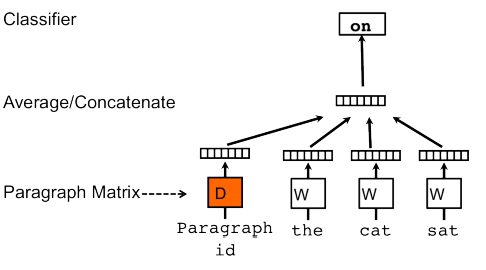

In [131]:
# Paragraph Vector - Distributed Memory (PV_DM) Model 
Image("../../raw_data/images/pv_dm.png", width=400)

In [74]:
sents = [' '.join(token) for token in texts if len(token) > 20]
len(sents)

118

In [75]:
import gensim

def read_corpus(text, tokens_only=False):
    for i, line in enumerate(text):
        if tokens_only:
            yield gensim.utils.simple_preprocess(line)
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(line), [i])
                
                
                
train_corpus = list(read_corpus(sents, tokens_only=False))
train_corpus

[TaggedDocument(words=['unlike', 'many', 'of', 'our', 'competitor', 'we', 'do', 'not', 'charge', 'rebook', 'or', 'exchange', 'fee', 'for', 'customers', 'who', 'change', 'their', 'itinerary', 'nor', 'have', 'we', 'ever', 'require', 'saturday', 'night', 'stay'], tags=[0]),
 TaggedDocument(words=['the', 'expect', 'consolidate', 'landing_fee', 'and', 'other', 'rental_expense', 'for', 'to', 'be', 'high', 'than', 'the', 'combine', 'result', 'on', 'per'], tags=[1]),
 TaggedDocument(words=['nevertheless', 'the', 'company', 'believe', 'it', 'continue', 'to', 'have', 'through', 'its', 'differentiation', 'of', 'southwest', 'from', 'all', 'of', 'its', 'by', 'not', 'charge', 'additional', 'fee', 'for', 'item_such_a_', 'and', 'bag', 'flight', 'change_seat', 'selection_snack', 'curb', 'side', 'check', 'in', 'and'], tags=[2]),
 TaggedDocument(words=['in', 'september', 'the', 'white', 'house', 'of', 'the', 'fee', 'to', 'trip', 'and', 'increase', 'that', 'would', 'raise', 'the', 'fee', 'to', 'per', 'one

In [86]:
from gensim.models import doc2vec

model = doc2vec.Doc2Vec(
      documents=train_corpus
    , size=50
    , min_count=4
    , iter=1000
)

print(model)

Doc2Vec(dm/m,d50,n5,w5,mc4,s0.001,t3)


In [87]:
%%time
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.iter)

Wall time: 3.55 s


1291566

In [104]:
model = doc2vec.Doc2Vec(alpha=0.025, min_alpha=0.025)  # use fixed learning rate
model.build_vocab(train_corpus)

for epoch in range(1000):
    model.train(train_corpus, total_examples=model.corpus_count, epochs=model.iter)
    model.alpha -= 0.002  # decrease the learning rate
    model.min_alpha = model.alpha  # fix the learning rate, no decay

In [105]:
print(model.wv)

In [106]:
model.infer_vector(['only', 'you', 'can', 'prevent', 'forest', 'fires'])

array([ 0.17222773, -0.02228558, -0.11576997, -0.02147023, -0.00841558,
       -0.02975876,  0.07465071,  0.00536888,  0.06541418,  0.14073066,
        0.11525098, -0.21767524, -0.11676117, -0.00177678,  0.00358539,
        0.04516327,  0.20129113, -0.0339815 ,  0.10229322, -0.16435196,
        0.06640128,  0.06056562,  0.04469901,  0.00729147,  0.03505935,
        0.10490328, -0.08257984, -0.02835166, -0.09661851, -0.18003416,
        0.0178279 ,  0.06221672,  0.02661187, -0.07900577,  0.13888614,
        0.09181631,  0.08188884, -0.07558136, -0.14566916, -0.09697036,
        0.15044646,  0.04345991,  0.01338842,  0.11184855,  0.2489598 ,
       -0.09591745, -0.05449501, -0.12785164, -0.07561693, -0.15790959,
        0.01471223,  0.13228935, -0.00989609,  0.01175714,  0.08500201,
        0.07980882,  0.12871411,  0.063977  ,  0.14404099, -0.01457309,
        0.01736755,  0.03064463,  0.0083587 ,  0.08850832,  0.0257157 ,
       -0.01372795, -0.10355943,  0.10476486, -0.09513692, -0.09

In [108]:
for ind, doc in enumerate(train_corpus):
    if ind > 5:
        break

    print('\nORIGINAL SENTENCE: {}'.format(' '.join(doc.words)))
    inferred_vector = model.infer_vector(train_corpus[ind].words)
    sims = model.docvecs.most_similar([inferred_vector], topn=2)
    rank = [docid for docid, sim in sims]
    print(rank)
    
    for rank_i in rank:
        print('    MATCH: {}'.format(' '.join(train_corpus[rank_i].words)))


ORIGINAL SENTENCE: unlike many of our competitor we do not charge rebook or exchange fee for customers who change their itinerary nor have we ever require saturday night stay
[26, 41]
    MATCH: airtran business_class and additional_perk such priority_board oversized_seat with additional_leg room_bonus frequent_flyer credit no bag fee and onboard
    MATCH: for the year end december the company incur consolidate acquisition relate_cost of million of fee and consult severance and technology integration cost and expense

ORIGINAL SENTENCE: the expect consolidate landing_fee and other rental_expense for to be high than the combine result on per
[3, 71]
    MATCH: in september the white house of the fee to trip and increase that would raise the fee to per one way_trip by
    MATCH: in addition southwest list and list preferred rapid rewards members book on airtran be eligible for free business_class upgrade no baggage fee and all other benefit that airtran rewards member enjoy

ORIGINAL S

### Category2Vec

SOURCE: 
- [Recommender System with Distributed Representation](https://www.slideshare.net/rakutentech/recommender-system-with-distributed-representation)
- [CAT2VEC: LEARNING DISTRIBUTED REPRESENTATION OF MULTI-FIELD CATEGORICAL DATA:](https://openreview.net/pdf?id=HyNxRZ9xg)


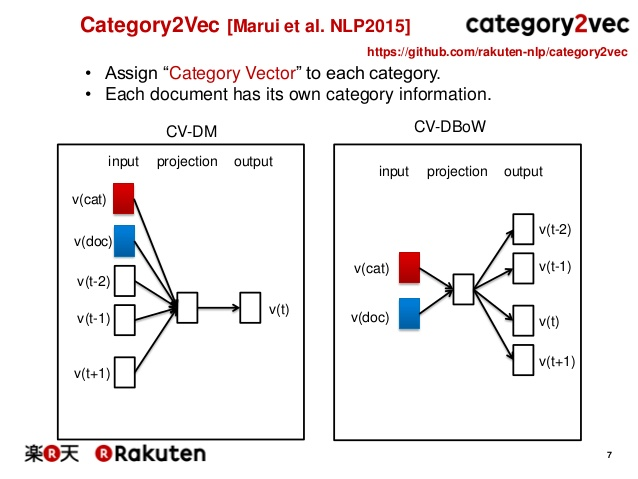

In [138]:
# Paragraph Vector - Distributed Memory (PV_DM) Model 
Image("../../raw_data/images/category2vec_architecture.jpg", width=400)

Resources to create content:
- [Word embeddings: exploration, explanation, and exploitation (with code in Python)](https://towardsdatascience.com/word-embeddings-exploration-explanation-and-exploitation-with-code-in-python-5dac99d5d795)
- [The amazing power of word vectors](https://blog.acolyer.org/2016/04/21/the-amazing-power-of-word-vectors/)
- [Don’tcount,predict! Asystematiccomparisonof context-countingvs.context-predictingsemanticvectors
](http://clic.cimec.unitn.it/marco/publications/acl2014/baroni-etal-countpredict-acl2014.pdf)
- [An Intuitive Understanding of Word Embeddings: From Count Vectors to Word2Vec](https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/)
- [Taming Text with the SVD](ftp://ftp.sas.com/techsup/download/EMiner/TamingTextwiththeSVD.pdf)